In [12]:
# Code to be used after the LULC bases have been created
# Determine the city bounding box, within which urban areas are classed as part of the city
# Determine the rural area extent to be used, which is proportional to the city area
# Determine the buffer zone area, which is based on the city outline

#import require packages
import pickle
import warnings
import scipy
from scipy import interpolate
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import earthpy as et
import numpy as np
import pandas as pd
import geopandas as gpd

#for creating buffer areas
from shapely.geometry import LineString
from shapely.ops import unary_union
#for finding the mode
from collections import Counter
#for calculating city shape measures
from scipy.spatial import distance

#go to directory to work in 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

#load in csv of city lons and lats
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
#CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon2.xlsx', index_col=None)

In [85]:
#### MANUAL ENTRIES ####

# Specify which city
CITY_COUNTRY = 'DJOUGOU_BENIN'

# then load up LULC data for the city
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)   

# set the city name for the plots        
city_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City.values[0]

Text(0, 0.5, 'y points')

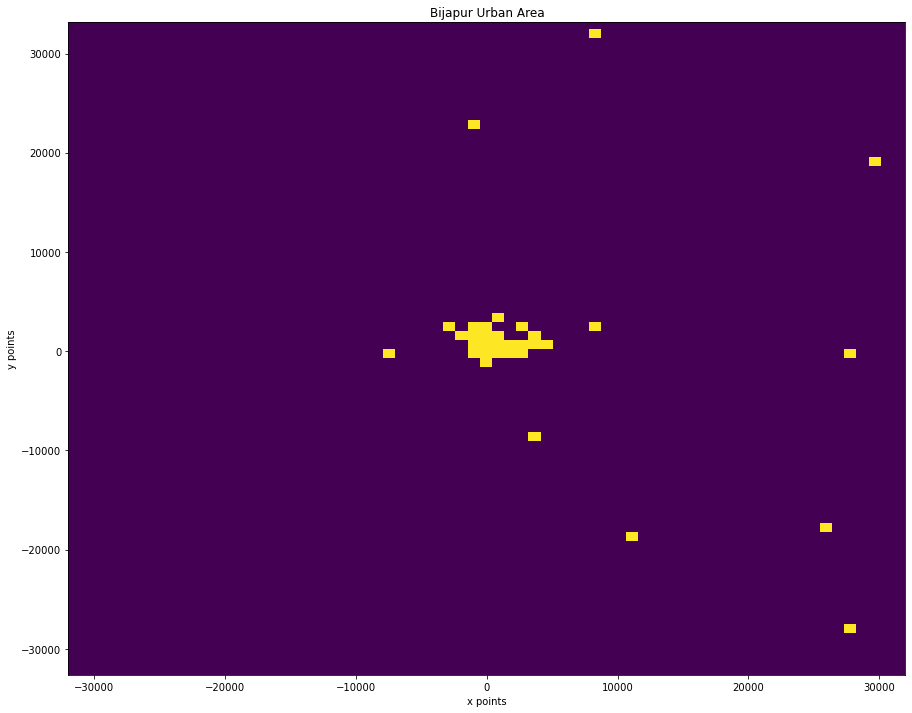

In [12]:
# Plot to look at city area to get bounding box
# get the points into the correct format

x_lu = LULC_df['x_points'].values
y_lu = LULC_df['y_points'].values
U_lu = LULC_df['is_urban_overall_2015'].values

X_lu, Y_lu = np.meshgrid(x_lu,y_lu)
Z_lu = scipy.interpolate.griddata((x_lu, y_lu), U_lu, (X_lu, Y_lu), method='nearest')

# inital plot
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (15,12))
axes.pcolormesh(X_lu, Y_lu, Z_lu, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')

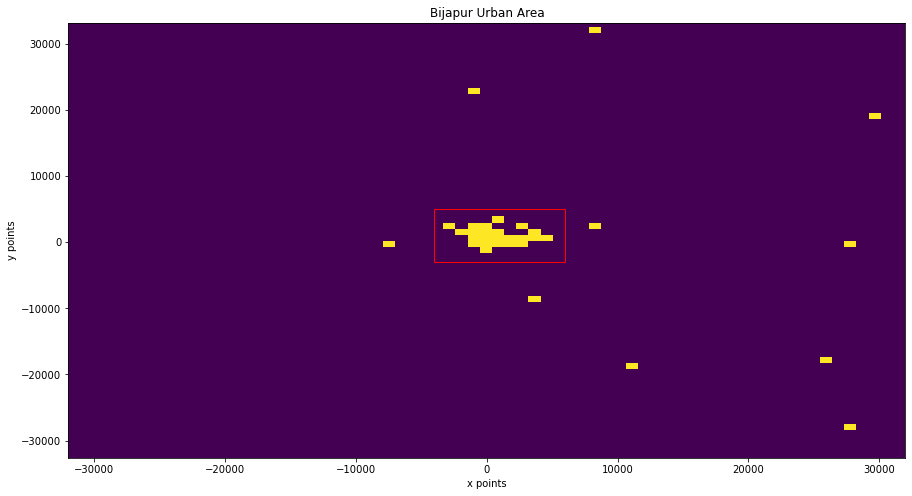

In [15]:
# Set bounding box and plot again

##### BOUNDING BOX ##### MANUAL ENTRY HERE #######
City_Bound_xmin =-4000
City_Bound_xmax = 6000
City_Bound_ymin = -3000
City_Bound_ymax = 5000
##################################################
box_height =  City_Bound_ymax - City_Bound_ymin
box_width = City_Bound_xmax - City_Bound_xmin
bbox = mpatches.Rectangle((City_Bound_xmin, City_Bound_ymin), box_width, box_height, angle = 0, 
                          linewidth=1,edgecolor='r',facecolor='none')

# inital plot
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (15,8))
axes.pcolormesh(X_lu, Y_lu, Z_lu, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')
axes.add_patch(bbox)

#save the plot as a png
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY))
plt.savefig('{}_urban_area_bbox.png'.format(city_name))

In [132]:
# calculate the city area
City_area = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                             & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax))
                            ]['is_urban_overall_2015'].sum()

area_years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',
              '2014','2015']

for n, year in enumerate(area_years):
    CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY), 'Area_{}'.format(year)] = LULC_df[(
        (LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) & (
        LULC_df['y_points'] > City_Bound_ymin) & ( LULC_df['y_points'] < City_Bound_ymax)
        )]['is_urban_overall_{}'.format(year)].sum()

    # ^ add in the area
    if len(LULC_df[LULC_df['is_urban_overall_{}'.format(year)] == 1]) == 0:
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY), 'City_length_{}'.format(year)] = 0
    else:
        #add in the longest city length to give an idea of its shape
        city_coords = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
            & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
            & (LULC_df['is_urban_overall_{}'.format(year)] == 1))].geometry
    
        dist_df = city_coords.geometry.apply(lambda g: city_coords.distance(g))
    
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY), 'City_length_{}'.format(year)] = (
            dist_df.max().max() + 1000)
        # (add 1000m as each pixel in 1000 so it 500m to the edge of each)
    
# add the new values into the city summary table
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY) ,'City_Area'] = City_area
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_xmin'] = City_Bound_xmin
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_xmax'] = City_Bound_xmax
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_ymin'] = City_Bound_ymin
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_ymax'] = City_Bound_ymax

# determine where the edge of the city is, which is used to calculate city height & width
city_x_min = min(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['x_points'] > City_Bound_xmin)].x_points)
city_x_max = max(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['x_points'] < City_Bound_xmax)].x_points)
city_y_min = min(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['y_points'] > City_Bound_ymin)].y_points)
city_y_max = max(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['y_points'] < City_Bound_ymax)].y_points)

city_height = city_y_max - city_y_min
city_width = city_x_max - city_x_min

#set bounds for the specification of rural area (based on 3 times the city or 5km from edge)
if -1.5*city_width > city_x_min - 5000:
    x_lower_bound = city_x_min - 5000
else:
    x_lower_bound = -1.5*city_width

if 1.5*city_width < city_x_max + 5000:
    x_upper_bound = city_x_max + 5000
else:
    x_upper_bound = 1.5*city_width   
    
    
if -1.5*city_height > city_y_min - 5000:
    y_lower_bound = city_y_min - 5000
else:
    y_lower_bound = -1.5*city_height
    
if 1.5*city_height < city_y_max + 5000:
    y_upper_bound = city_y_max + 5000
else:
    y_upper_bound = 1.5*city_height



# calculate the cooridnate box that specifies the rural area to be used (based on 3 times the city or 5km from edge)
max_lon_0 = LULC_df[LULC_df['x_points'] == (min(LULC_df[LULC_df['x_points'] >= x_upper_bound].x_points))].Longitude.values[0]
min_lon_0 = LULC_df[LULC_df['x_points'] == (max(LULC_df[LULC_df['x_points'] <= x_lower_bound].x_points))].Longitude.values[0]

max_lat_0 = LULC_df[LULC_df['y_points'] == (min(LULC_df[LULC_df['y_points'] >= y_upper_bound].y_points))].Latitude.values[0]
min_lat_0 = LULC_df[LULC_df['y_points'] == (max(LULC_df[LULC_df['y_points'] <= y_lower_bound].y_points))].Latitude.values[0]

# round up to 5 dps
if max_lon_0 > 0:
    max_lon = round((max_lon_0 + 0.000005),5)
else:
    max_lon = round((max_lon_0 - 0.000005),5)

if min_lon_0 > 0:
    min_lon = round((min_lon_0 - 0.000005),5)
else:
    min_lon = round((min_lon_0 + 0.000005),5)
        
if max_lat_0 > 0:    
    max_lat = round((max_lat_0 + 0.000005),5)
else:
    max_lat = round((max_lat_0 - 0.000005),5)
        
if min_lat_0 > 0:
    min_lat = round((min_lat_0 - 0.000005),5)
else:
    min_lat = round((min_lat_0 + 0.000005),5)

# add these to the table    
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'max_lon'] = max_lon
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'min_lon'] = min_lon
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'max_lat'] = max_lat
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'min_lat'] = min_lat

# crop the original LULC dataset so it is the calculated size
LULC_df_crop = LULC_df[((LULC_df.Latitude >= min_lat) & (LULC_df.Latitude <= max_lat) & (
    LULC_df.Longitude >= min_lon) & (LULC_df.Longitude <= max_lon))].copy()

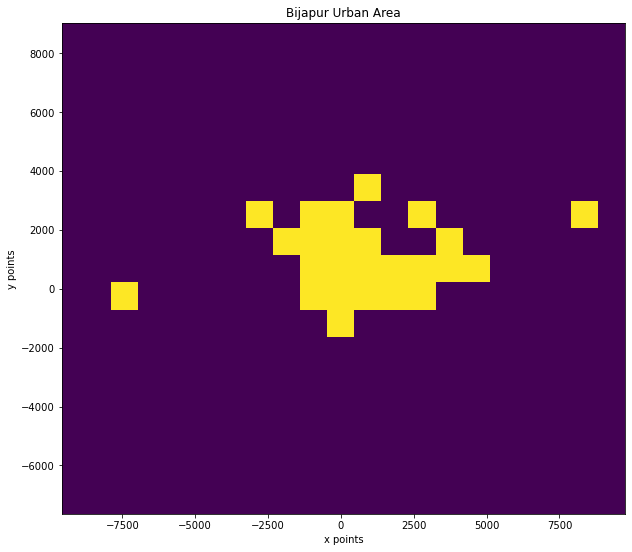

In [17]:
###############################################
####### OBSERVATION POINT #####################
###############################################

# Look at the cropped area

x = LULC_df_crop['x_points'].values
y = LULC_df_crop['y_points'].values
U = LULC_df_crop['is_urban_overall_2015'].values

X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
axes.pcolormesh(X, Y, Z, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')

#save the plot as a png
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY))
plt.savefig('{}_urban_area.png'.format(city_name))

In [18]:
#Find a 5km buffer area
LULC_df_crop["buffer_radius"] = LULC_df_crop.geometry.buffer(5000)
city_points = LULC_df_crop[((LULC_df_crop['is_urban_2015'] == 1) & (LULC_df_crop['x_points'] > City_Bound_xmin)
               & (LULC_df_crop['x_points'] < City_Bound_xmax) & (LULC_df_crop['y_points'] > City_Bound_ymin)  
               & (LULC_df_crop['y_points'] < City_Bound_ymax))].copy()

#create overall buffer polygon
buffer_poly = unary_union(city_points.buffer_radius)

#add the buffer into the LULC dataset
point = LULC_df_crop.geometry
LULC_df_crop['buffer_zone'] = point.within(buffer_poly)
LULC_df_crop['buffer'] = 0
LULC_df_crop.loc[(LULC_df_crop['buffer_zone']) & (LULC_df_crop['is_urban_2015'] == 0),'buffer'] = 1


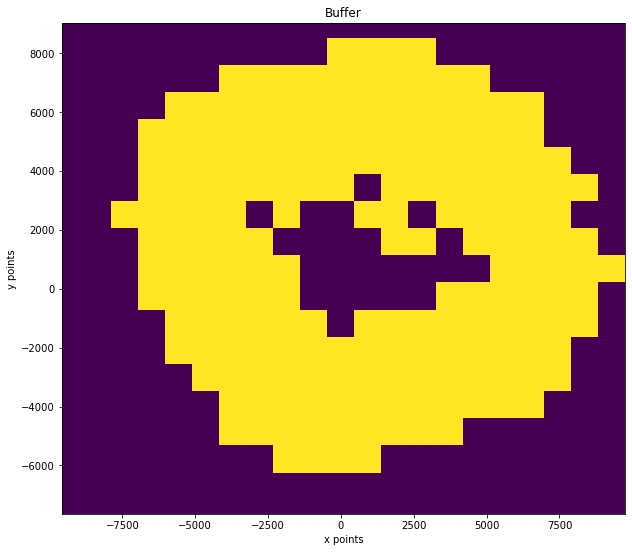

In [19]:
###############################################
####### OBSERVATION POINT #####################
###############################################

# look at buffer area

x = LULC_df_crop['x_points'].values
y = LULC_df_crop['y_points'].values
U = LULC_df_crop['buffer'].values

X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
axes.pcolormesh(X, Y, Z, shading = 'auto')
axes.set_title('Buffer')
axes.set_xlabel('x points')
axes.set_ylabel('y points')

#save the plot as a png
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY))
plt.savefig('{}_urban_buffer_area.png'.format(city_name))

In [20]:
#determine the class for each pixel in the specified year
#5

lccs_class_overall_2000_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2000'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2000_list.append(mode[0])

#lccs_class_overall_2005
lccs_class_overall_2005_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2005'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2005_list.append(mode[0])

#lccs_class_overall_2010
lccs_class_overall_2010_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2010'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2010_list.append(mode[0])

#lccs_class_overall_2015
lccs_class_overall_2015_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2015'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2015_list.append(mode[0])
    
    
#add the classifications back into the LULC_df
LULC_df_crop['lccs_class_overall_2000'] = lccs_class_overall_2000_list
LULC_df_crop['lccs_class_overall_2005'] = lccs_class_overall_2005_list
LULC_df_crop['lccs_class_overall_2010'] = lccs_class_overall_2010_list
LULC_df_crop['lccs_class_overall_2015'] = lccs_class_overall_2015_list

#save the new LULC dataframes as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files', 
                      'LULC_Pickles', 'Crop_wbuffer_LULC'))
pickle_name = 'LULC_{}.pkl'.format(CITY_COUNTRY)
with open(pickle_name, 'wb') as f:
    pickle.dump(LULC_df_crop, f)
    
#save the updates to the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon.to_excel('CITY_COUNTRY_lat_lon.xlsx', index = False)

In [142]:
##### LOOP CODE #####

for i_count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):    

    # load up LULC data for the city
    with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)   
    
    # get the bounds from the table 
    City_Bound_xmin = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_xmin.values[0]
    City_Bound_xmax = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_xmax.values[0]
    City_Bound_ymin = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_ymin.values[0]
    City_Bound_ymax = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_ymax.values[0]
   
    # calculate the city area
    City_area = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                                 & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax))
                                ]['is_urban_overall_2015'].sum()

    area_years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',
                  '2014','2015']
    
    for n, year in enumerate(area_years):
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY), 'Area_{}'.format(year)] = LULC_df[(
            (LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) & (
            LULC_df['y_points'] > City_Bound_ymin) & ( LULC_df['y_points'] < City_Bound_ymax)
            )]['is_urban_overall_{}'.format(year)].sum()
        # ^ add in the area

        if len(LULC_df[LULC_df['is_urban_overall_{}'.format(year)] == 1]) == 0:
            CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY), 'City_length_{}'.format(year)] = 0
        else:
            #add in the longest city length to give an idea of its shape
            city_coords = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_{}'.format(year)] == 1))].geometry
    
            dist_df = city_coords.geometry.apply(lambda g: city_coords.distance(g))
    
            CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY), 'City_length_{}'.format(year)] = (
                dist_df.max().max() + 1000)
            # (add 1000m as each pixel in 1000 so it 500m to the edge of each)
    
    # determine where the edge of the city is, which is used to calculate city height & width
    city_x_min = min(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['x_points'] > City_Bound_xmin)].x_points)
    city_x_max = max(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['x_points'] < City_Bound_xmax)].x_points)
    city_y_min = min(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['y_points'] > City_Bound_ymin)].y_points)
    city_y_max = max(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['y_points'] < City_Bound_ymax)].y_points)

    city_height = city_y_max - city_y_min
    city_width = city_x_max - city_x_min
    
    #set bounds for the specification of rural area (based on 3 times the city or 5km from edge)
    if -1.5*city_width > city_x_min - 5000:
        x_lower_bound = city_x_min - 5000
    else:
        x_lower_bound = -1.5*city_width

    if 1.5*city_width < city_x_max + 5000:
        x_upper_bound = city_x_max + 5000
    else:
        x_upper_bound = 1.5*city_width   
    
    
    if -1.5*city_height > city_y_min - 5000:
        y_lower_bound = city_y_min - 5000
    else:
        y_lower_bound = -1.5*city_height
    
    if 1.5*city_height < city_y_max + 5000:
        y_upper_bound = city_y_max + 5000
    else:
        y_upper_bound = 1.5*city_height

    # calculate the cooridnate box that specifies the rural area to be used (based on 3 times the city or 5km from edge)
    max_lon_0 = LULC_df[LULC_df['x_points'] == (min(LULC_df[LULC_df['x_points'] >= x_upper_bound].x_points))].Longitude.values[0]
    min_lon_0 = LULC_df[LULC_df['x_points'] == (max(LULC_df[LULC_df['x_points'] <= x_lower_bound].x_points))].Longitude.values[0]

    max_lat_0 = LULC_df[LULC_df['y_points'] == (min(LULC_df[LULC_df['y_points'] >= y_upper_bound].y_points))].Latitude.values[0]
    min_lat_0 = LULC_df[LULC_df['y_points'] == (max(LULC_df[LULC_df['y_points'] <= y_lower_bound].y_points))].Latitude.values[0]    
    
    # round up to 5 dps
    if max_lon_0 > 0:
        max_lon = round((max_lon_0 + 0.000005),5)
    else:
        max_lon = round((max_lon_0 - 0.000005),5)

    if min_lon_0 > 0:
        min_lon = round((min_lon_0 - 0.000005),5)
    else:
        min_lon = round((min_lon_0 + 0.000005),5)
        
    if max_lat_0 > 0:    
        max_lat = round((max_lat_0 + 0.000005),5)
    else:
        max_lat = round((max_lat_0 - 0.000005),5)
        
    if min_lat_0 > 0:
        min_lat = round((min_lat_0 - 0.000005),5)
    else:
        min_lat = round((min_lat_0 + 0.000005),5)

    # add these to the table    
    CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'max_lon'] = max_lon
    CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'min_lon'] = min_lon
    CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'max_lat'] = max_lat
    CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'min_lat'] = min_lat
    # add city width and height to the table
    CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'city_width'] = city_width
    CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'city_height'] = city_height
    
    # crop the original LULC dataset so it is the calculated size
    LULC_df_crop = LULC_df[((LULC_df.Latitude >= min_lat) & (LULC_df.Latitude <= max_lat) & (
        LULC_df.Longitude >= min_lon) & (LULC_df.Longitude <= max_lon))].copy()
    
    #Find a 5km buffer area
    LULC_df_crop["buffer_radius"] = LULC_df_crop.geometry.buffer(5000)
    city_points = LULC_df_crop[((LULC_df_crop['is_urban_2015'] == 1) & (LULC_df_crop['x_points'] > City_Bound_xmin)
               & (LULC_df_crop['x_points'] < City_Bound_xmax) & (LULC_df_crop['y_points'] > City_Bound_ymin)  
               & (LULC_df_crop['y_points'] < City_Bound_ymax))].copy()

    #create overall buffer polygon
    buffer_poly = unary_union(city_points.buffer_radius)

    #add the buffer into the LULC dataset
    point = LULC_df_crop.geometry
    LULC_df_crop['buffer_zone'] = point.within(buffer_poly)
    LULC_df_crop['buffer'] = 0
    LULC_df_crop.loc[(LULC_df_crop['buffer_zone']) & (LULC_df_crop['is_urban_2015'] == 0),'buffer'] = 1
    
    #determine the class for each pixel in the specified year
    #5

    lccs_class_overall_2000_list = []

    for a in range(len(LULC_df_crop)):
        #get list of pixel classifications
        row = LULC_df_crop.iloc[a]
        pixel_list = []

        for i in [1,2,3,4,5]: #the numbers for the 5 pixels
            pixel_name = 'lccs_class_{}_2000'.format(i)
            x = row[pixel_name]
            pixel_list.append(x)
        #find the mode of the list
        counter = Counter(pixel_list)
        max_count = max(counter.values())
        mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
        lccs_class_overall_2000_list.append(mode[0])

    #lccs_class_overall_2005
    lccs_class_overall_2005_list = []

    for a in range(len(LULC_df_crop)):
        #get list of pixel classifications
        row = LULC_df_crop.iloc[a]
        pixel_list = []

        for i in [1,2,3,4,5]: #the numbers for the 5 pixels
            pixel_name = 'lccs_class_{}_2005'.format(i)
            x = row[pixel_name]
            pixel_list.append(x)
        #find the mode of the list
        counter = Counter(pixel_list)
        max_count = max(counter.values())
        mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
        lccs_class_overall_2005_list.append(mode[0])

    #lccs_class_overall_2010
    lccs_class_overall_2010_list = []

    for a in range(len(LULC_df_crop)):
        #get list of pixel classifications
        row = LULC_df_crop.iloc[a]
        pixel_list = []

        for i in [1,2,3,4,5]: #the numbers for the 5 pixels
            pixel_name = 'lccs_class_{}_2010'.format(i)
            x = row[pixel_name]
            pixel_list.append(x)
        #find the mode of the list
        counter = Counter(pixel_list)
        max_count = max(counter.values())
        mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
        lccs_class_overall_2010_list.append(mode[0])

    #lccs_class_overall_2015
    lccs_class_overall_2015_list = []

    for a in range(len(LULC_df_crop)):
        #get list of pixel classifications
        row = LULC_df_crop.iloc[a]
        pixel_list = []

        for i in [1,2,3,4,5]: #the numbers for the 5 pixels
            pixel_name = 'lccs_class_{}_2015'.format(i)
            x = row[pixel_name]
            pixel_list.append(x)
        #find the mode of the list
        counter = Counter(pixel_list)
        max_count = max(counter.values())
        mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
        lccs_class_overall_2015_list.append(mode[0])
    
    
    #add the classifications back into the LULC_df
    LULC_df_crop['lccs_class_overall_2000'] = lccs_class_overall_2000_list
    LULC_df_crop['lccs_class_overall_2005'] = lccs_class_overall_2005_list
    LULC_df_crop['lccs_class_overall_2010'] = lccs_class_overall_2010_list
    LULC_df_crop['lccs_class_overall_2015'] = lccs_class_overall_2015_list

    #save the new LULC dataframes as pickle
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files', 
                      'LULC_Pickles', 'Crop_wbuffer_LULC'))
    pickle_name = 'LULC_{}.pkl'.format(CITY_COUNTRY)
    with open(pickle_name, 'wb') as f:
        pickle.dump(LULC_df_crop, f)
    
    #save the updates to the city info table
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
    CITY_COUNTRY_lat_lon.to_excel('CITY_COUNTRY_lat_lon.xlsx', index = False)
    

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the

Text(0, 0.5, 'Area (km2)')

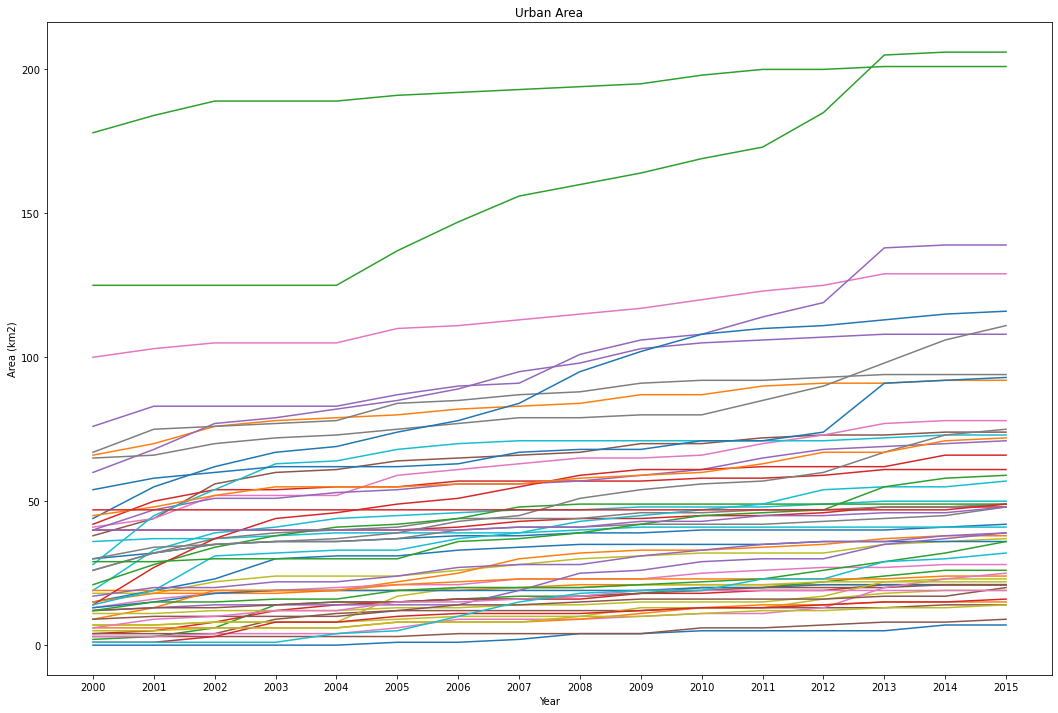

In [156]:
# plot the city areas
year_list = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',
                  '2014','2015']

fig, axes = plt.subplots(figsize=(18,12))

for country_i, City in enumerate(CITY_COUNTRY_lat_lon.City):
    area_list = []
    for n, year in enumerate(area_years):
        area_list.append(CITY_COUNTRY_lat_lon['Area_{}'.format(year)][country_i])
        
    axes.plot(year_list, area_list)
    
axes.set_title('Urban Area')
axes.set_xlabel('Year')
axes.set_ylabel('Area (km2)')

In [162]:
### Observations ###

#### MANUAL ENTRIES ####

# Specify which city
CITY_COUNTRY = 'ADO_EKITI_NIGERIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
# then load up LULC data for the city
with open('UHI_Project_Pickle_Files\LULC_Pickles\Crop_wbuffer_LULC\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)   

# set the city name for the plots        
city_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City.values[0]
City_Bound_xmin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City_Bound_xmin.values[0]
City_Bound_xmax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City_Bound_xmax.values[0]
City_Bound_ymin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City_Bound_ymin.values[0]
City_Bound_ymax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City_Bound_ymax.values[0]

In [170]:
##### FITTING AN ELLIPSE ####
year = '2015'
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

city_x = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_{}'.format(year)] == 1))].x_points.values

city_y = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_{}'.format(year)] == 1))].y_points.values

city_xy = np.array(list(zip(city_x, city_y)))

ell = EllipseModel()
ell.estimate(city_xy)

xc, yc, a, b, theta = ell.params

print("center = ",  (xc, yc))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

center =  (704.9424518371815, -72.60669180406407)
angle of rotation =  1.4677220591186408
axes =  (3912.2861169546904, 2912.7541295743044)


In [243]:
minor_ax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].minor_ax_2015.values[0]
major_ax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].major_ax_2015.values[0]
theta = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].ell_theta_2015.values[0]
city_len = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY].City_length_2015.values[0]

def in_ellipse_check(xc, yc, major_ax, minor_ax, theta):
    e1 = Ellipse((xc, yc), 2*(major_ax), 2*(minor_ax), theta*180/np.pi)
    in_ellipse = [e1.contains_point((point)) for point in city_xy]
    data = np.array(city_xy)
    mask = np.array(in_ellipse)
    if data[~mask].size:
        check = False
    else:
        check = True
    return check

if in_ellipse_check(xc, yc, major_ax, minor_ax, theta) == False:
    major_ax = city_len/2
    
while in_ellipse_check(xc, yc, major_ax, minor_ax, theta) == False:
    minor_ax = minor_ax + 500
    

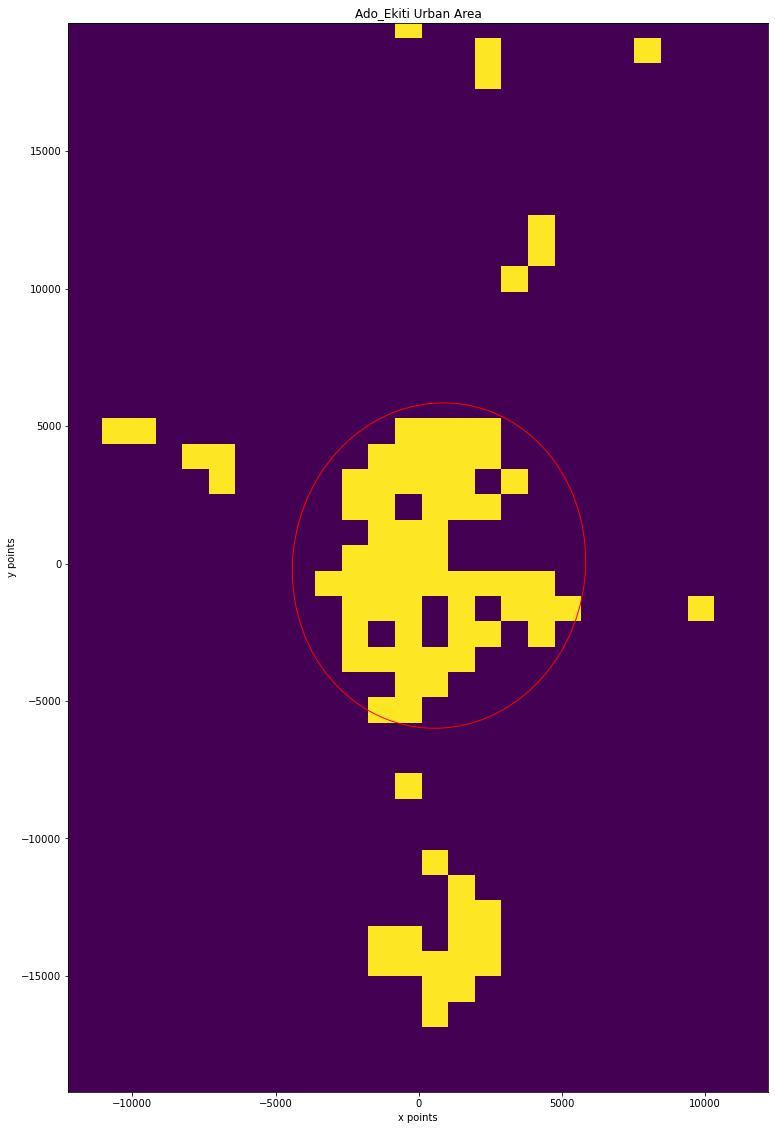

In [246]:

#### CROPPED AREA ####
x = LULC_df['x_points'].values
y = LULC_df['y_points'].values
U = LULC_df['is_urban_overall_2015'].values

X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
axes.pcolormesh(X, Y, Z, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')

ell_patch = Ellipse((xc, yc), 2*(major_ax), 2*(minor_ax+500), theta*180/np.pi, edgecolor='red', facecolor='none')

axes.add_patch(ell_patch)

#save the plot as a png
#os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY))
#plt.savefig('{}_urban_area.png'.format(city_name))

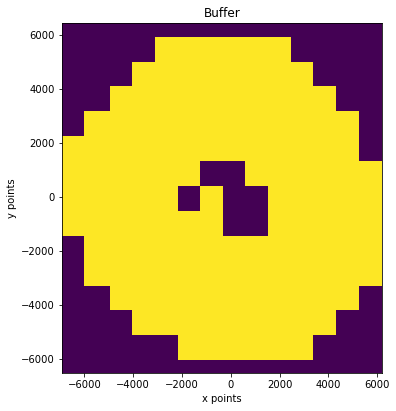

In [6]:
#### BUFFER AREA ####

x = LULC_df['x_points'].values
y = LULC_df['y_points'].values
U = LULC_df['buffer'].values

X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
axes.pcolormesh(X, Y, Z, shading = 'auto')
axes.set_title('Buffer')
axes.set_xlabel('x points')
axes.set_ylabel('y points')

#save the plot as a png
os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY))
plt.savefig('{}_urban_buffer_area.png'.format(city_name))

In [255]:
### ADD IN MAJOR AND MINOR AXIS, ECCENTRICITY ###

## LOOP CODE ##

ell = EllipseModel()                                                          # define the ellipse model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))  # go to directory to work in 
#def in_ellipse_check(xc, yc, major_ax, minor_ax, theta):                      # define function to check if point inside 
#    e1 = Ellipse((xc, yc), 2*(major_ax), 2*(minor_ax), theta*180/np.pi)       # the ellipse 
#    in_ellipse = [e1.contains_point((point)) for point in city_xy]
#    data = np.array(city_xy)
#    mask = np.array(in_ellipse)
#    if data[~mask].size:
#        check = False
#    else:
#        check = True
#    return check

for i_count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):    

    # load up LULC data for the city
    with open('UHI_Project_Pickle_Files\LULC_Pickles\Crop_wbuffer_LULC\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)   
    
    # get the bounds from the table 
    City_Bound_xmin = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_xmin.values[0]
    City_Bound_xmax = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_xmax.values[0]
    City_Bound_ymin = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_ymin.values[0]
    City_Bound_ymax = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City_Bound_ymax.values[0]


    area_years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',
                  '2014','2015']
    
    for n, year in enumerate(area_years):
        if len(LULC_df[LULC_df['is_urban_overall_{}'.format(year)] == 1]) == 0:
            
            major_ax, minor_ax, theta, ecc = np.nan, np.nan,np.nan, np.nan
        else:     
            city_x = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_{}'.format(year)] == 1))].x_points.values

            city_y = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_{}'.format(year)] == 1))].y_points.values

            city_xy = np.array(list(zip(city_x, city_y)))

            ell.estimate(city_xy)
            xc, yc, a, b, theta = ell.params
            major_ax = a + 1000 # (add 1000m as each pixel in 1000 so it 500m to the edge of each)
            minor_ax = b + 1000
            #city_len = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY
            #                                )]['City_length_{}'.format(year)].values[0]

            #if in_ellipse_check(xc, yc, major_ax, minor_ax, theta) == False:
            #    major_ax = city_len/2
    
            #while (in_ellipse_check(xc, yc, major_ax, minor_ax, theta) == False) & (minor_ax < major_ax):
            #    minor_ax = minor_ax + 1000   
        
            ecc = np.sqrt(major_ax_final**2 - minor_ax_final**2) / major_ax_final
    
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'major_ax_{}'.format(year)] = major_ax
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'minor_ax_{}'.format(year)] = minor_ax
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'ell_theta_{}'.format(year)] = theta
        CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'eccen_{}'.format(year)] = ecc

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


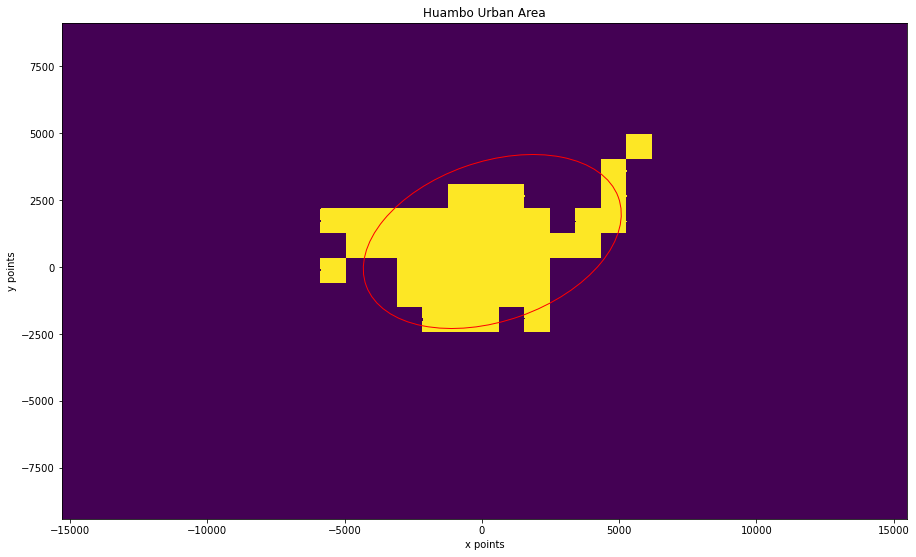

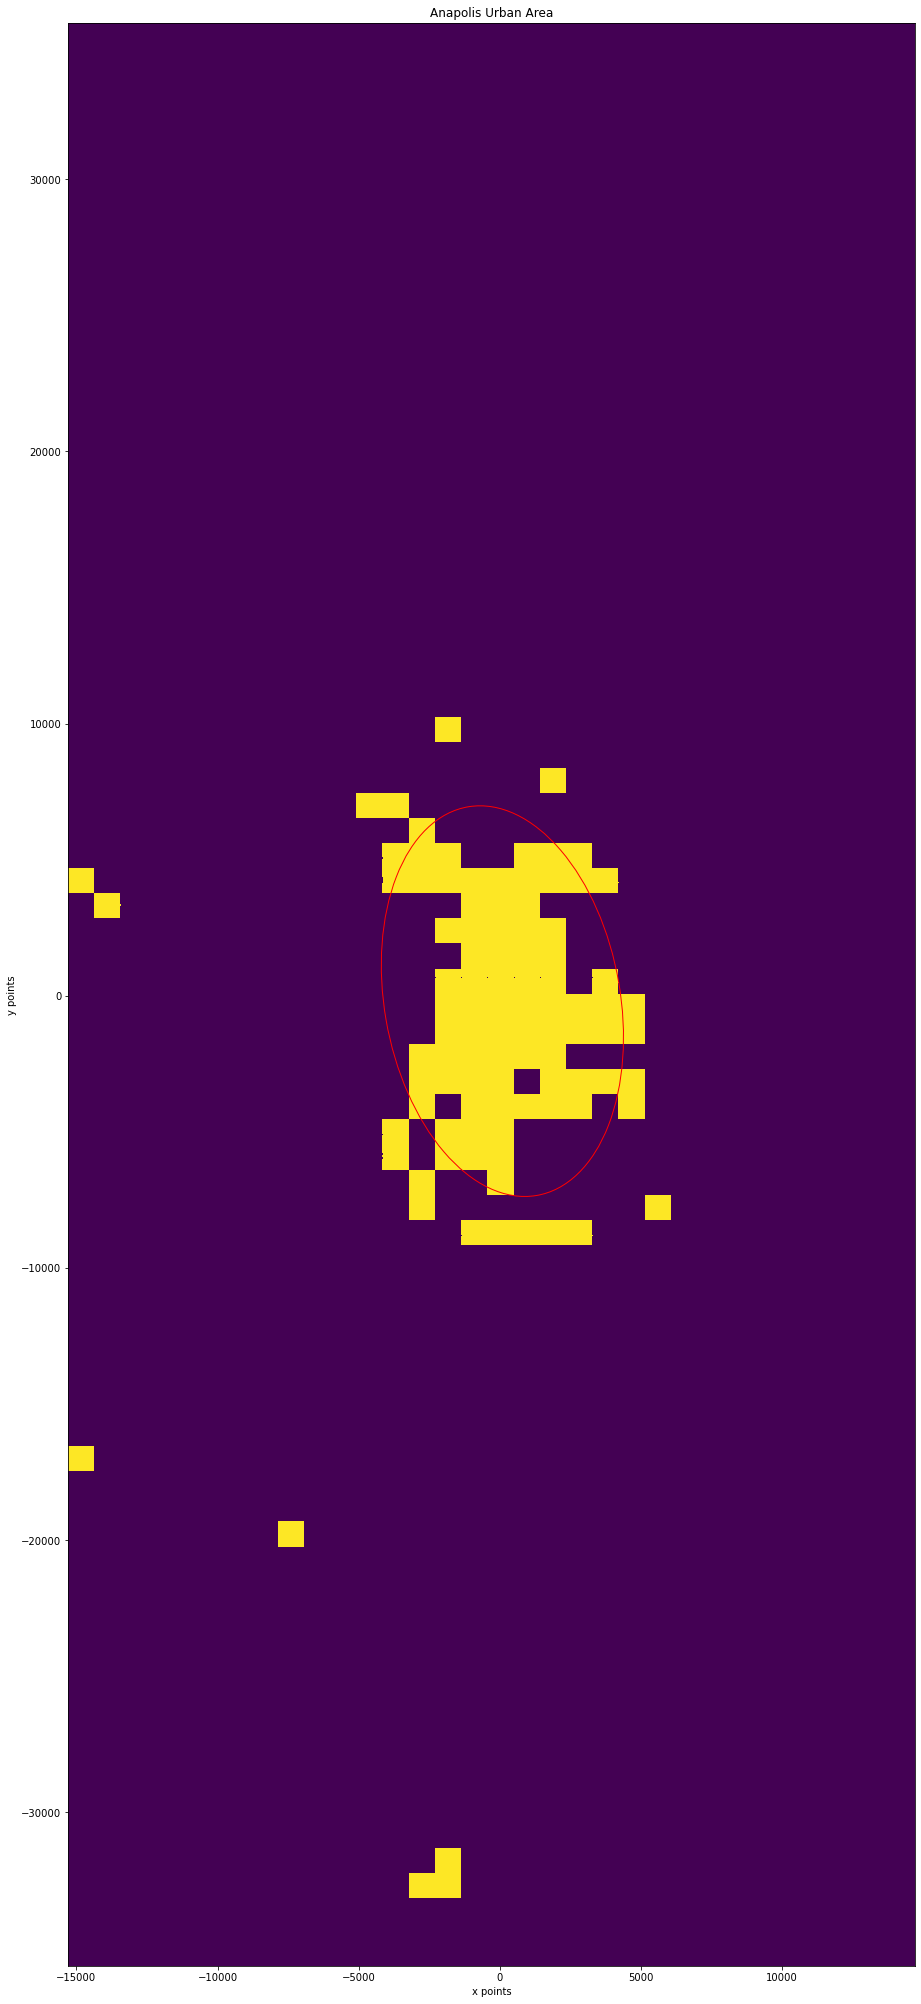

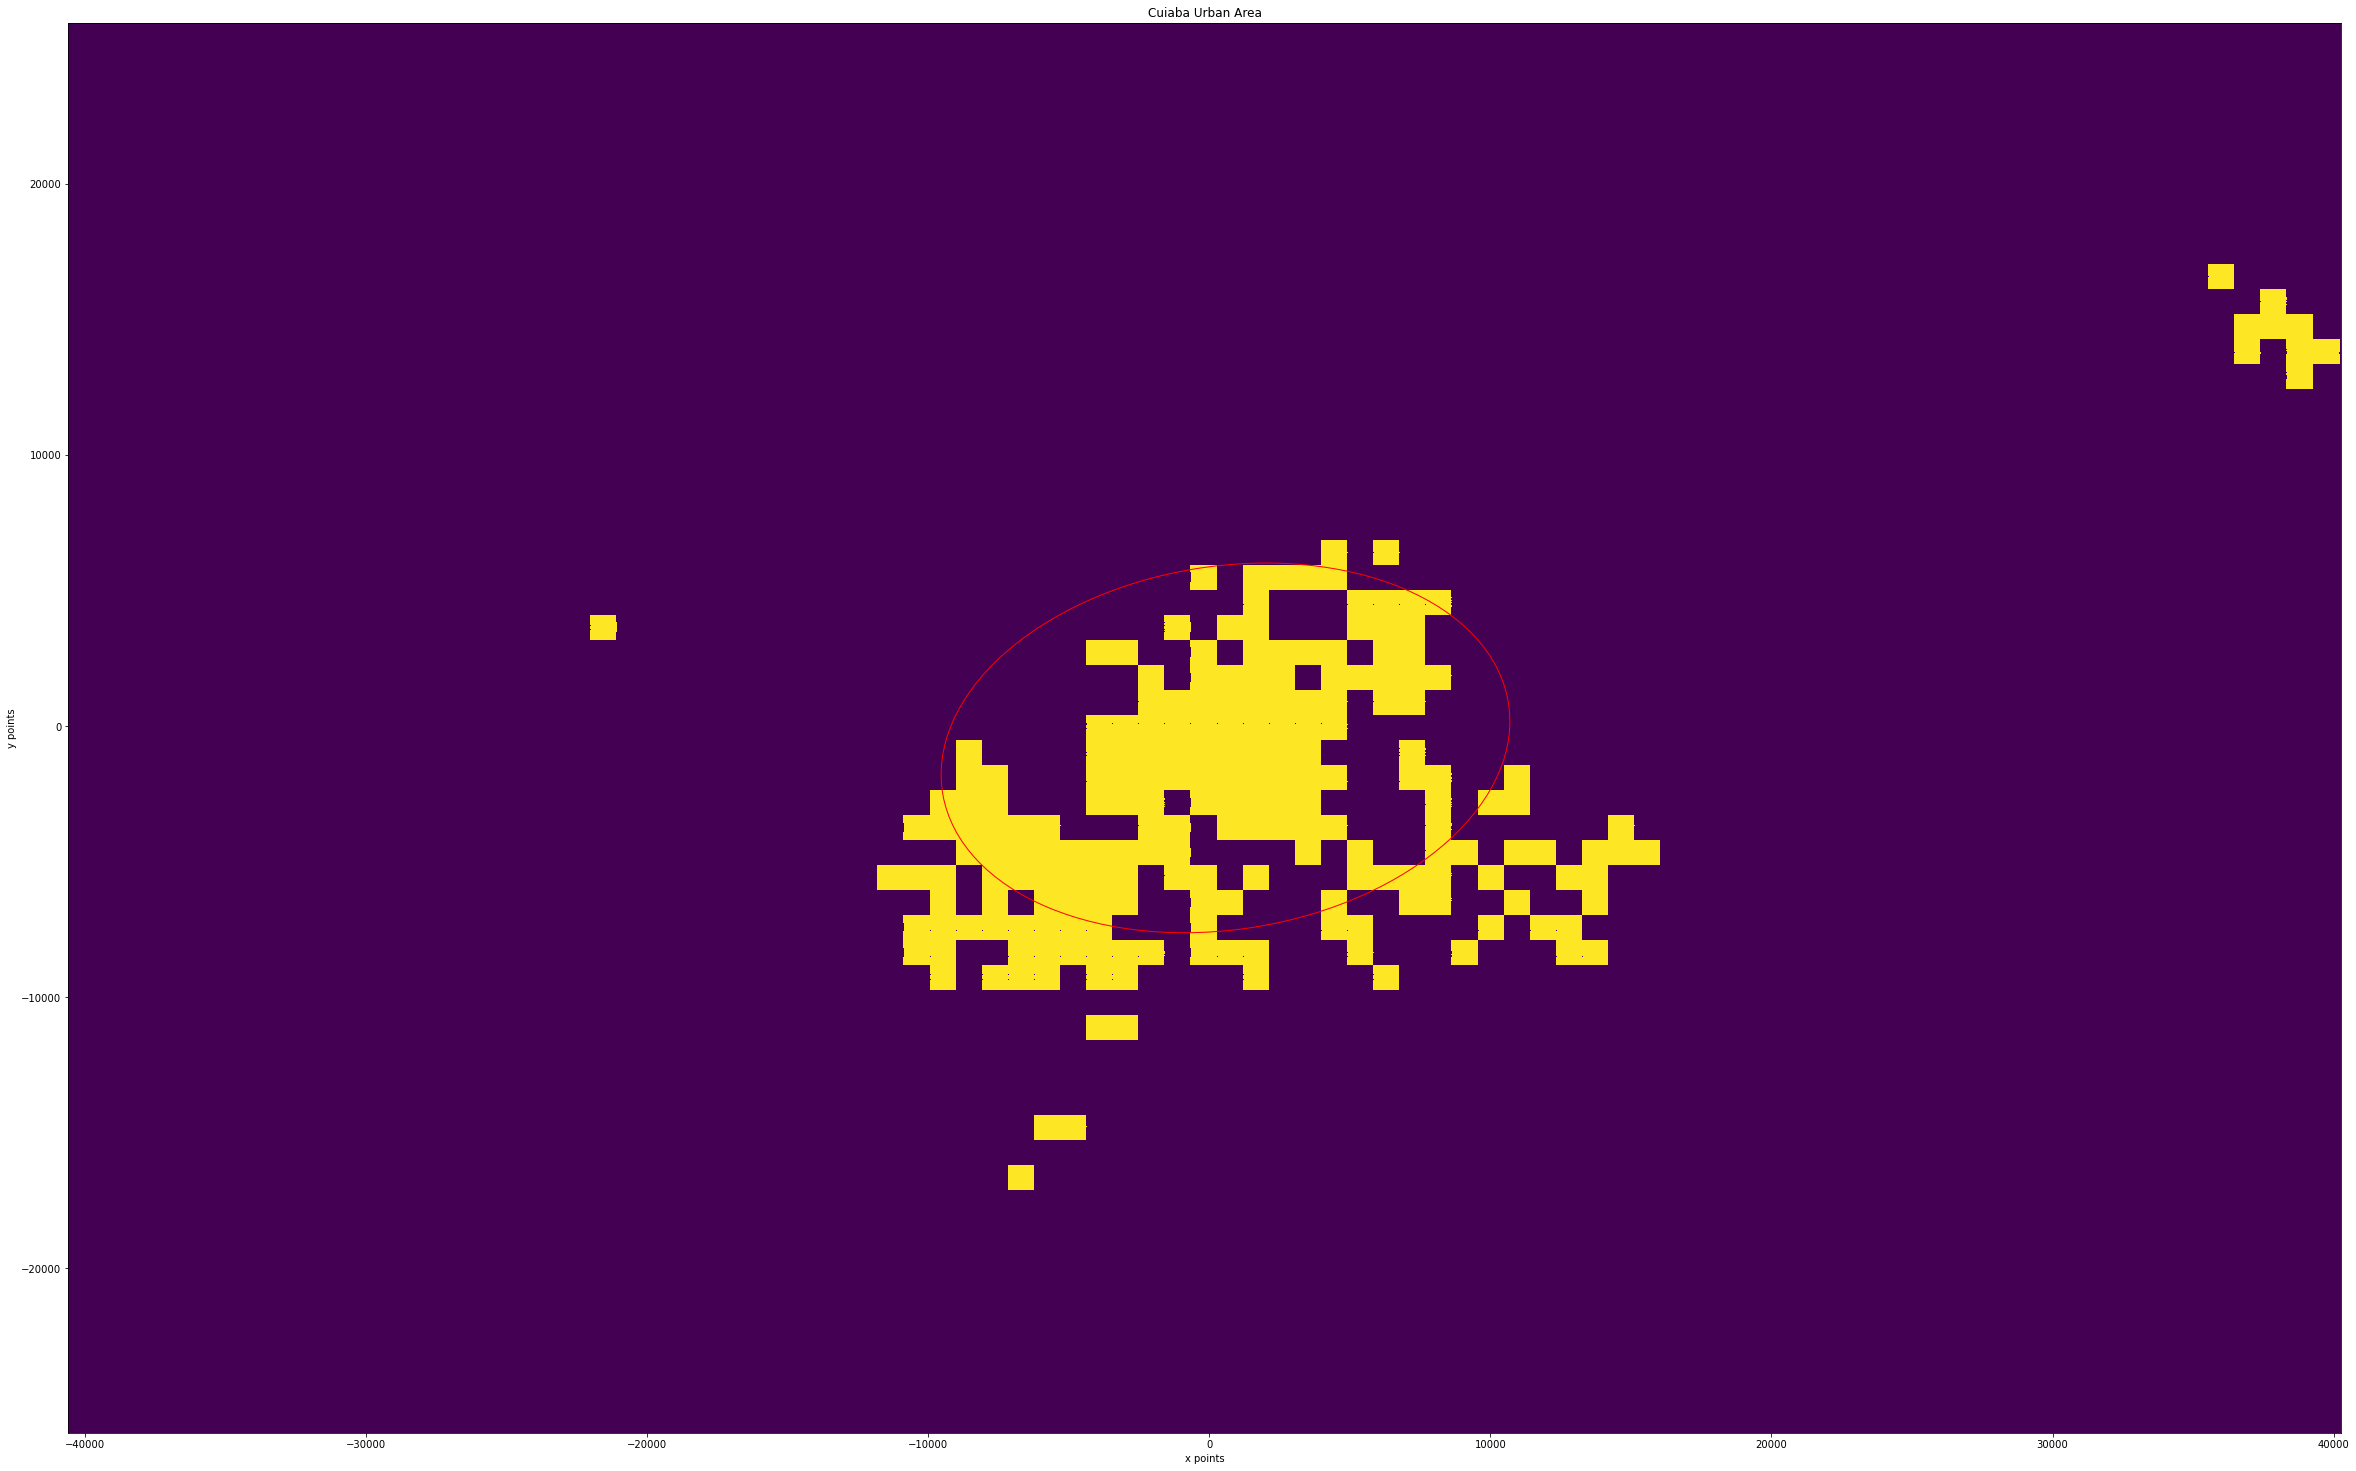

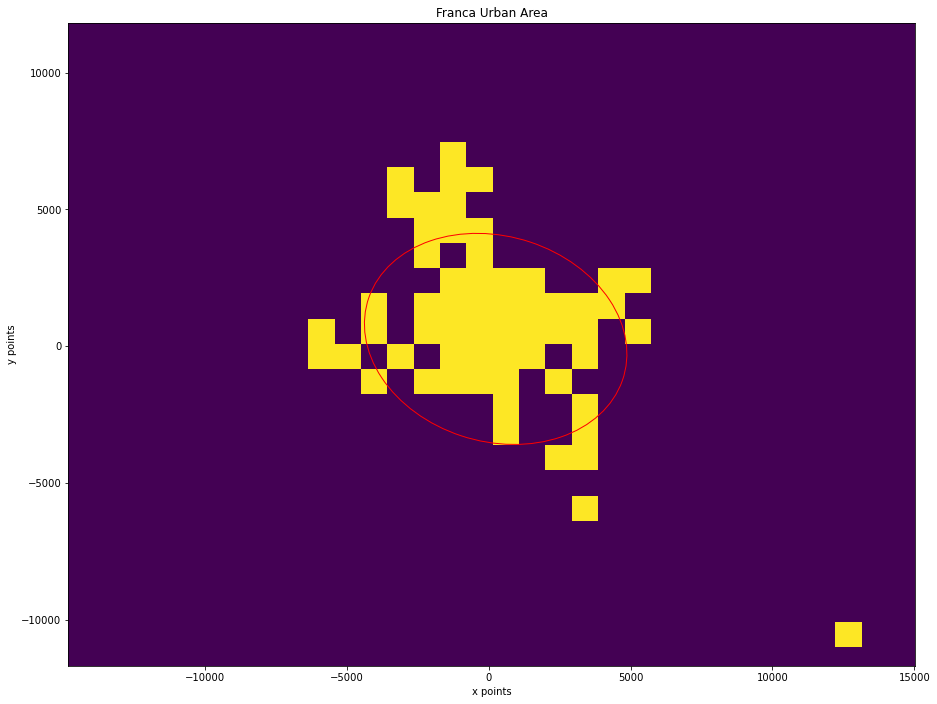

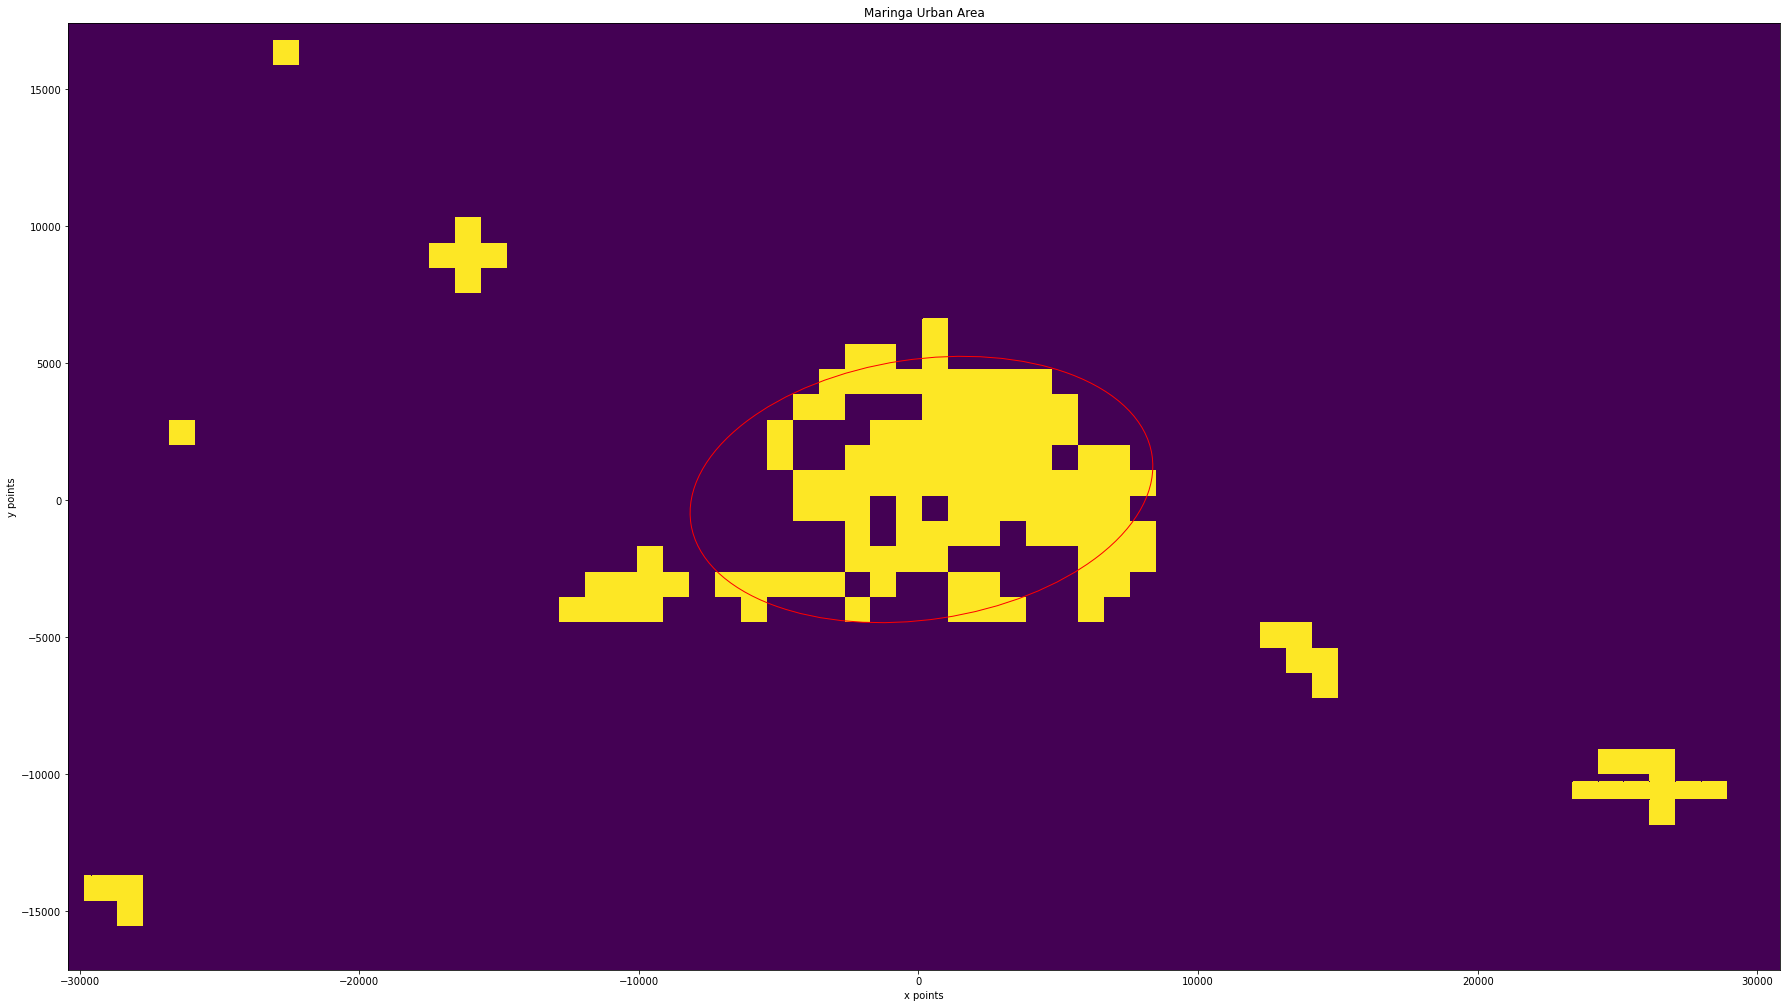

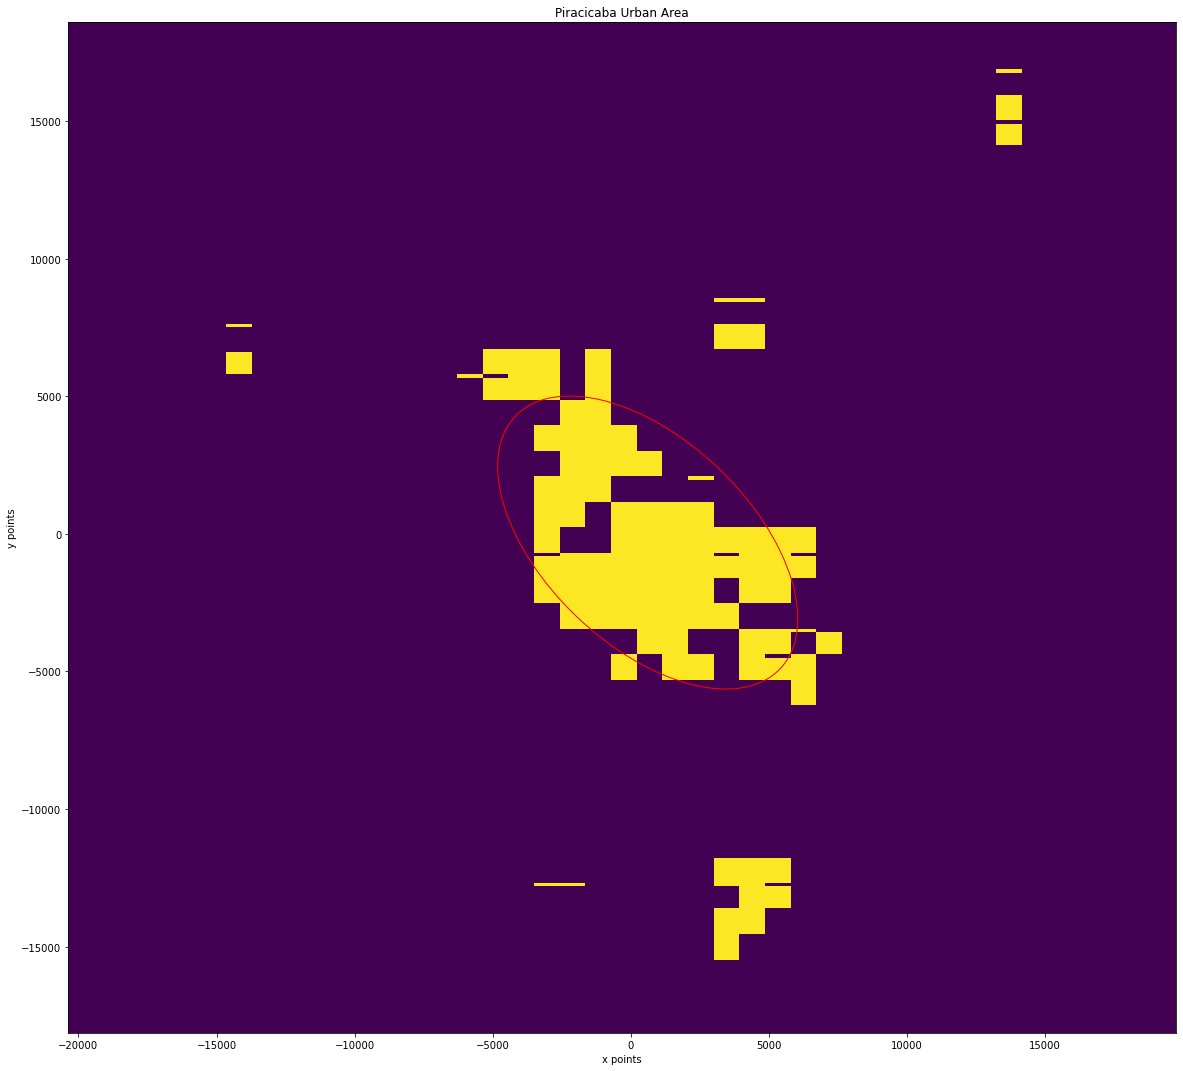

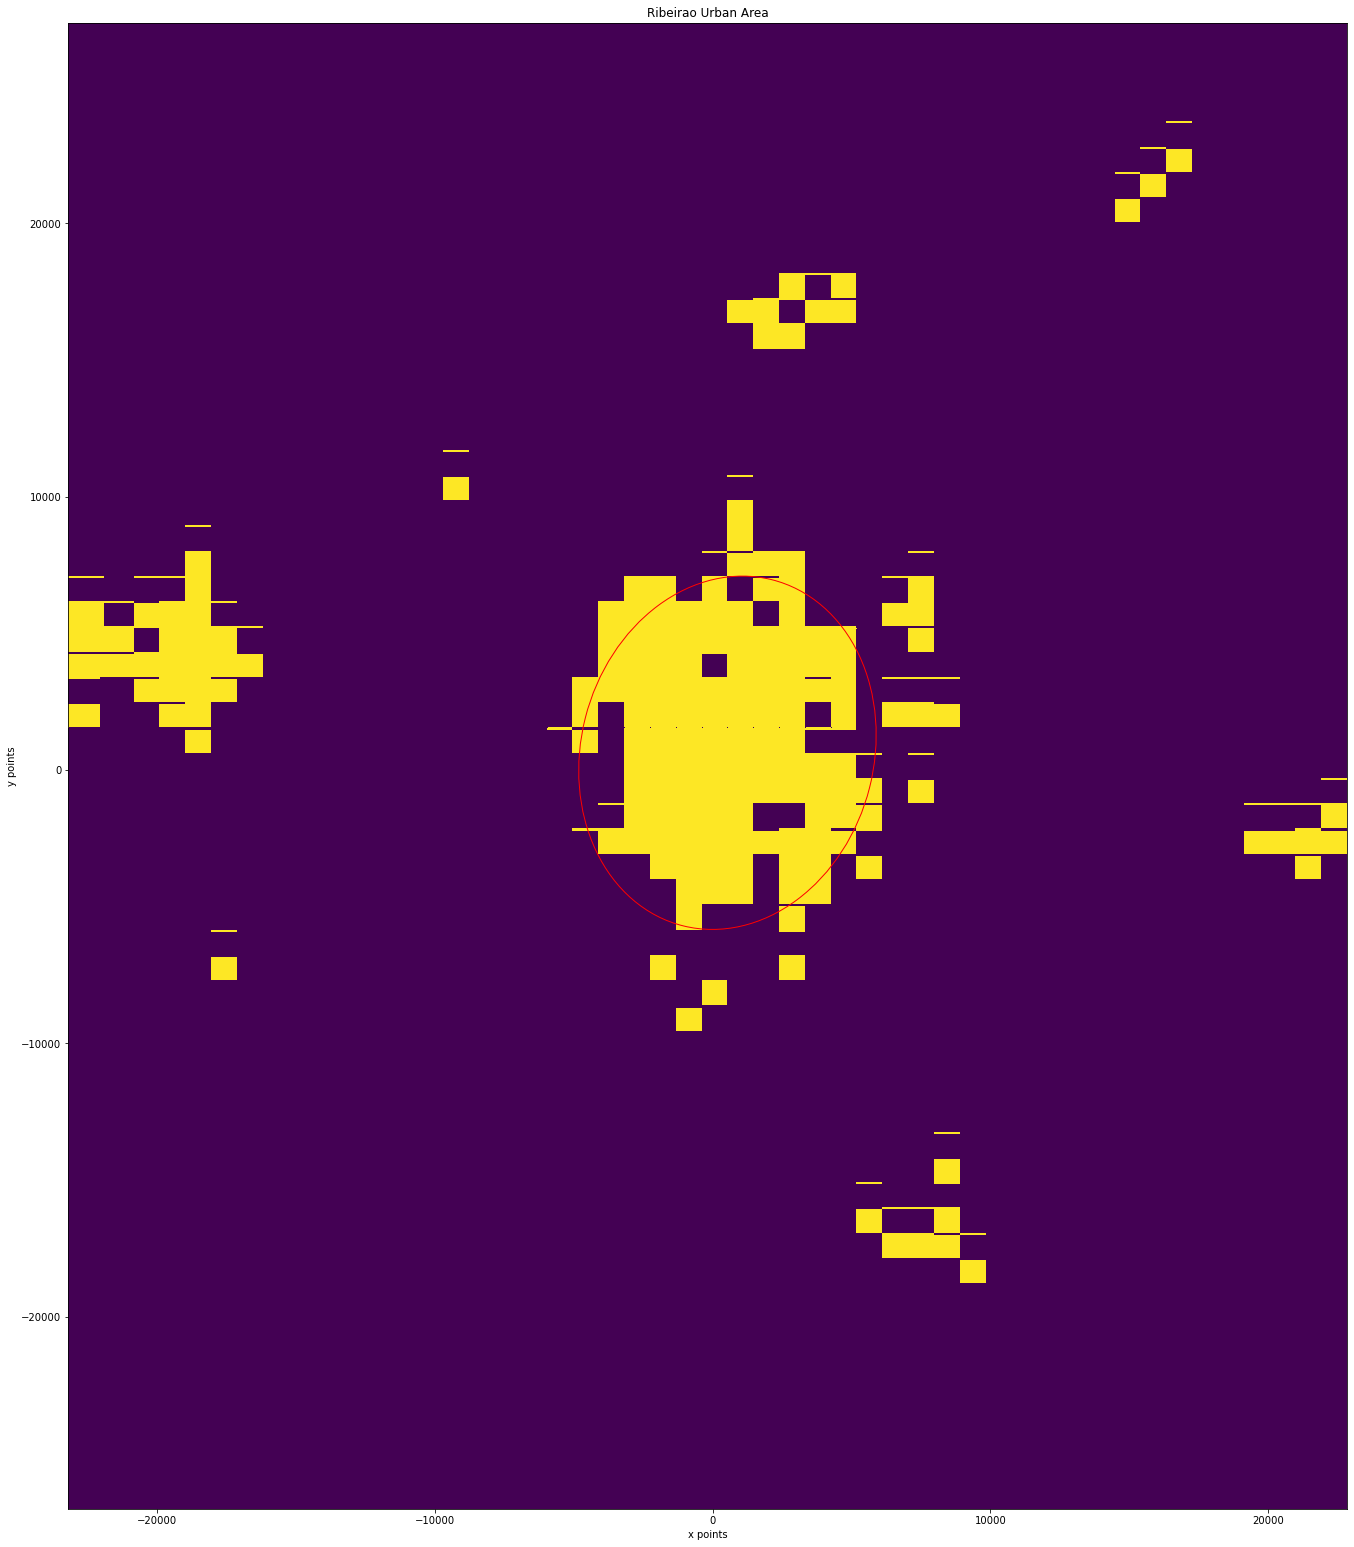

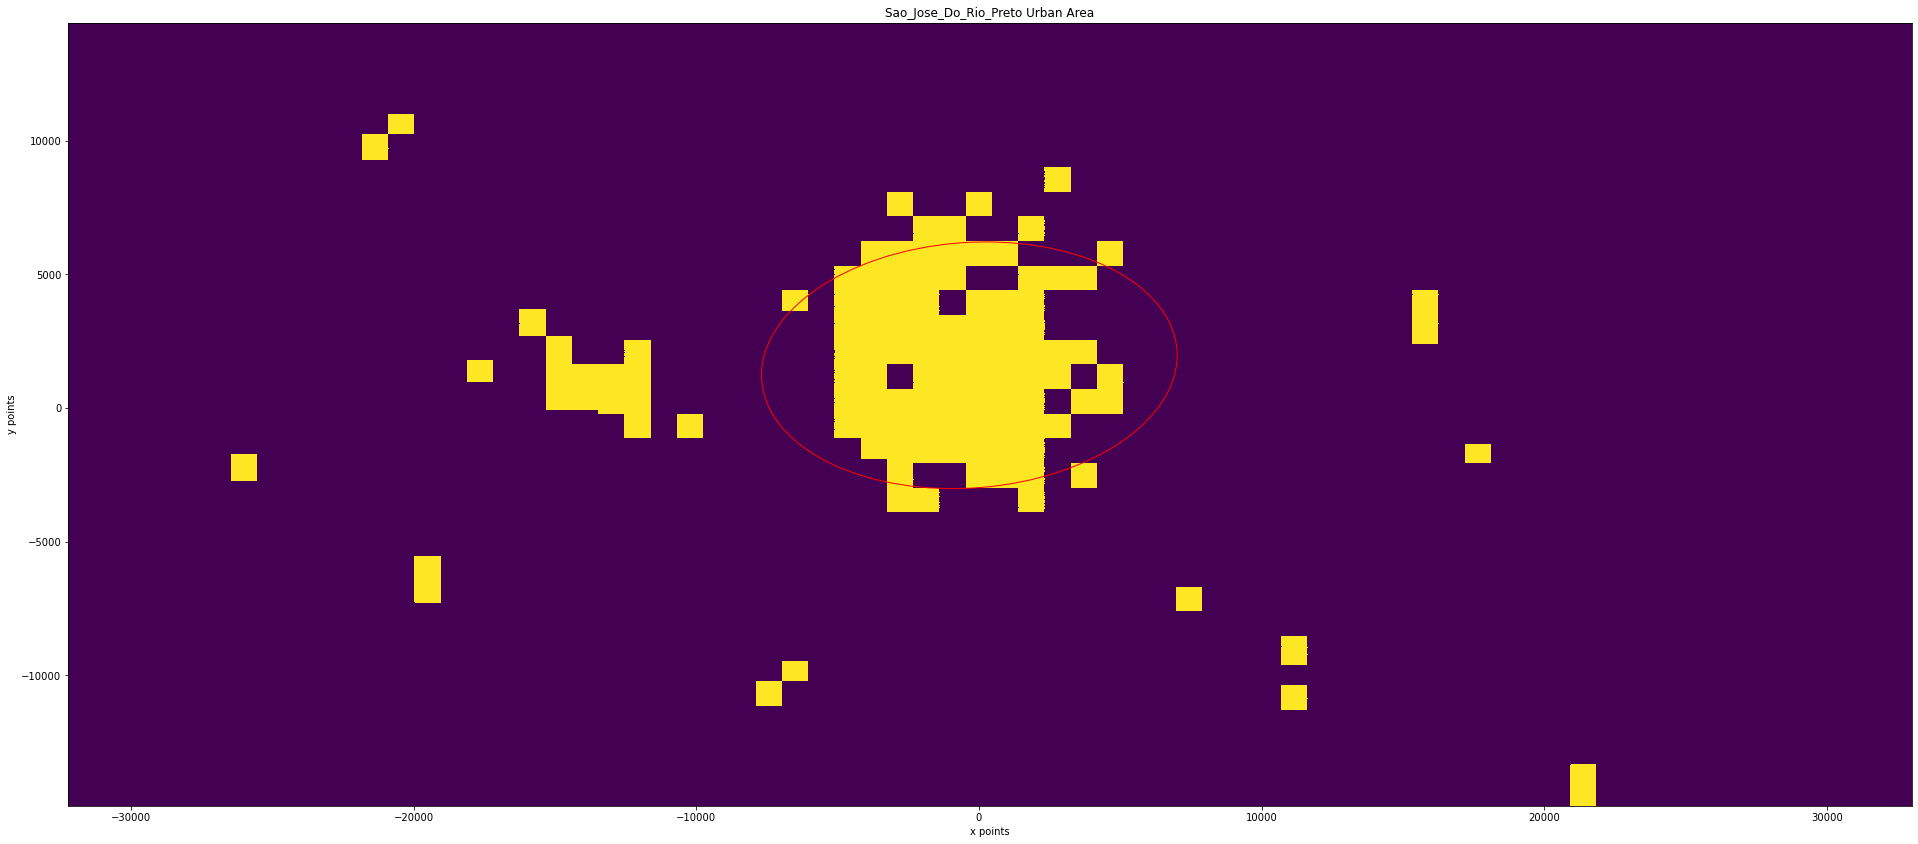

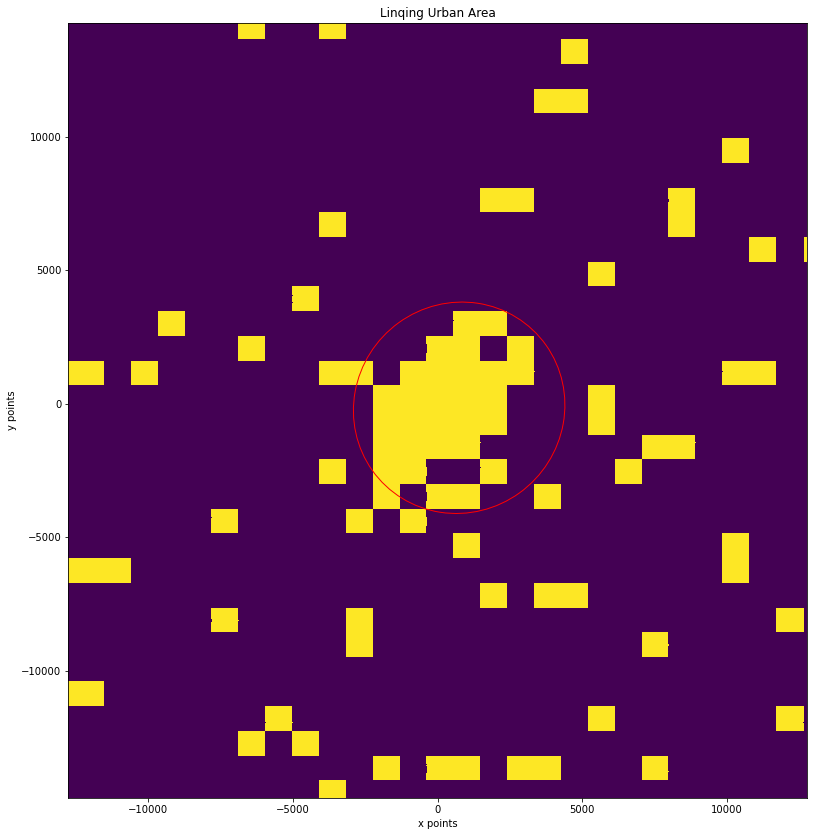

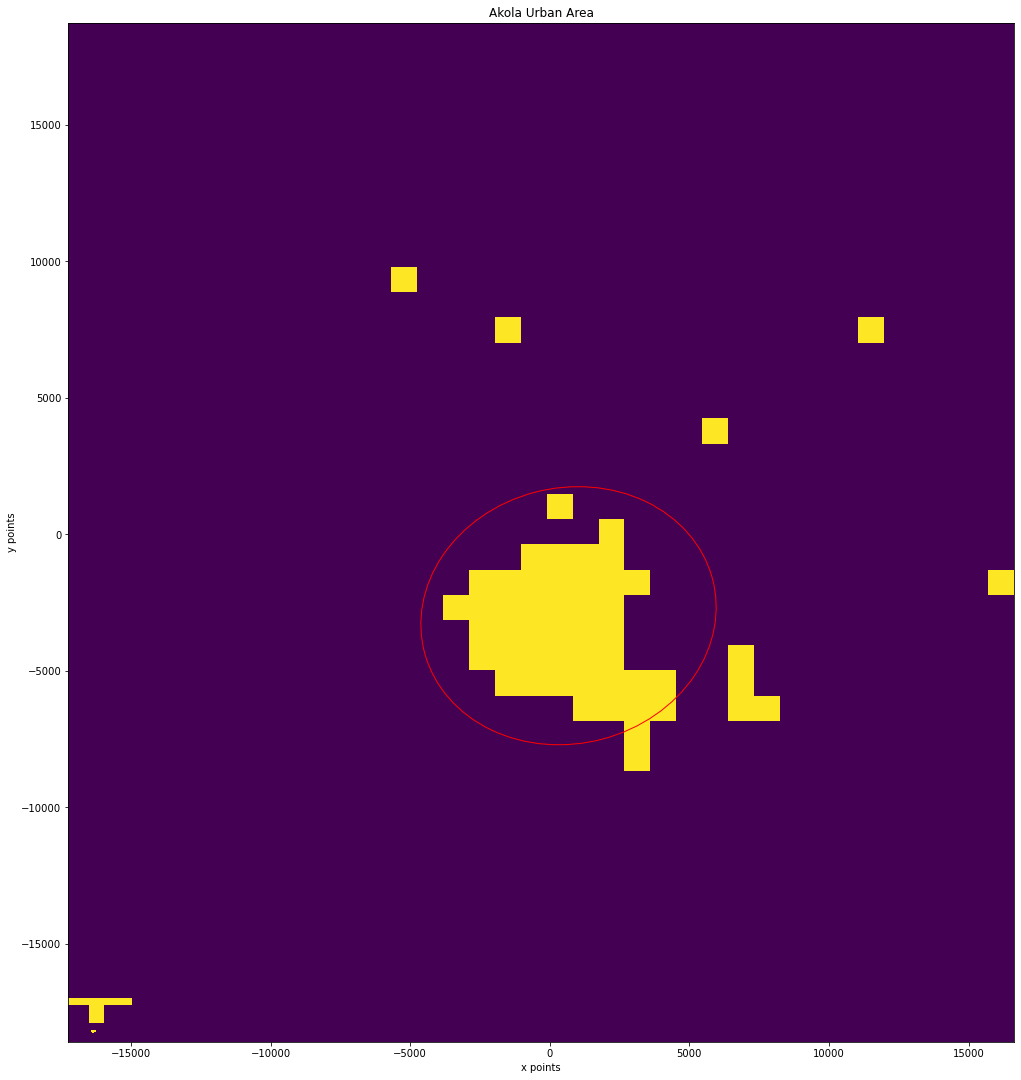

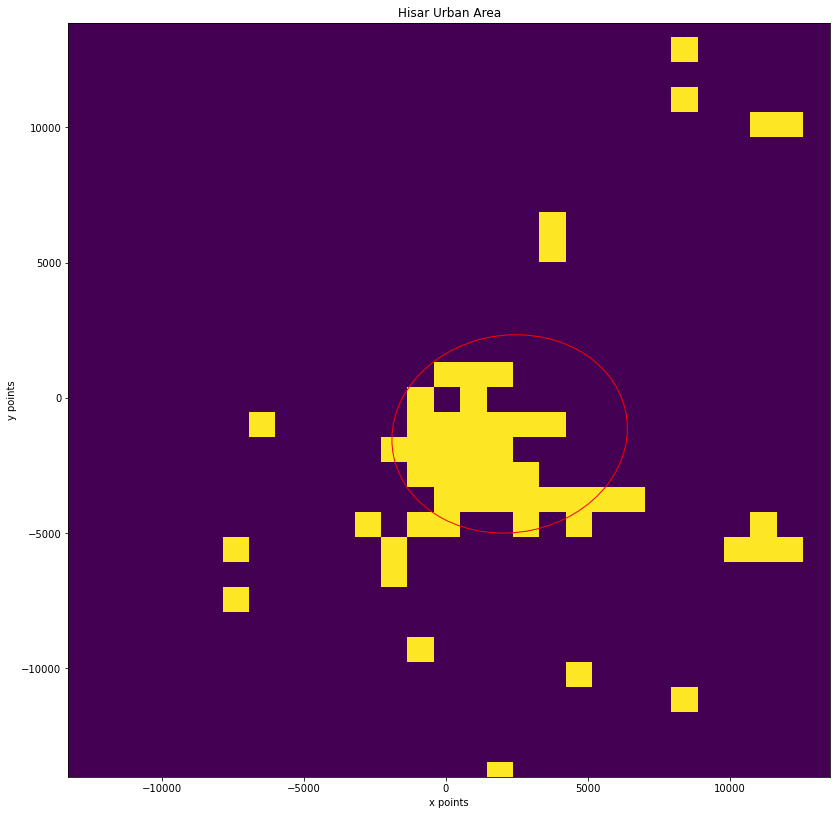

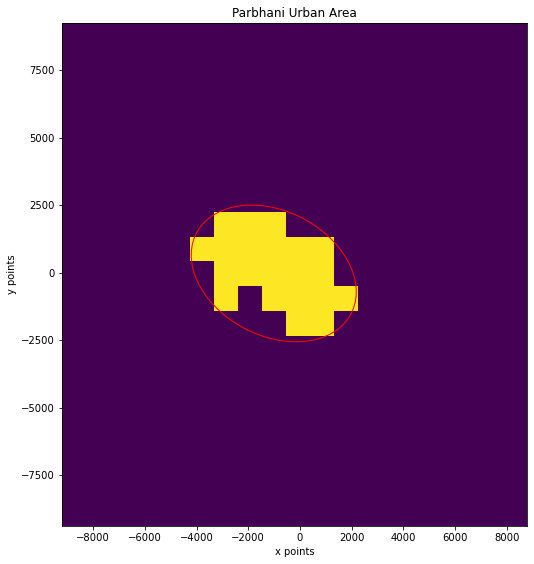

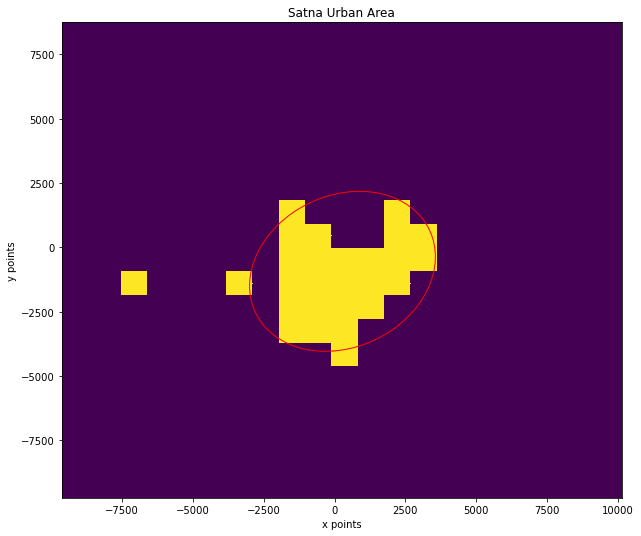

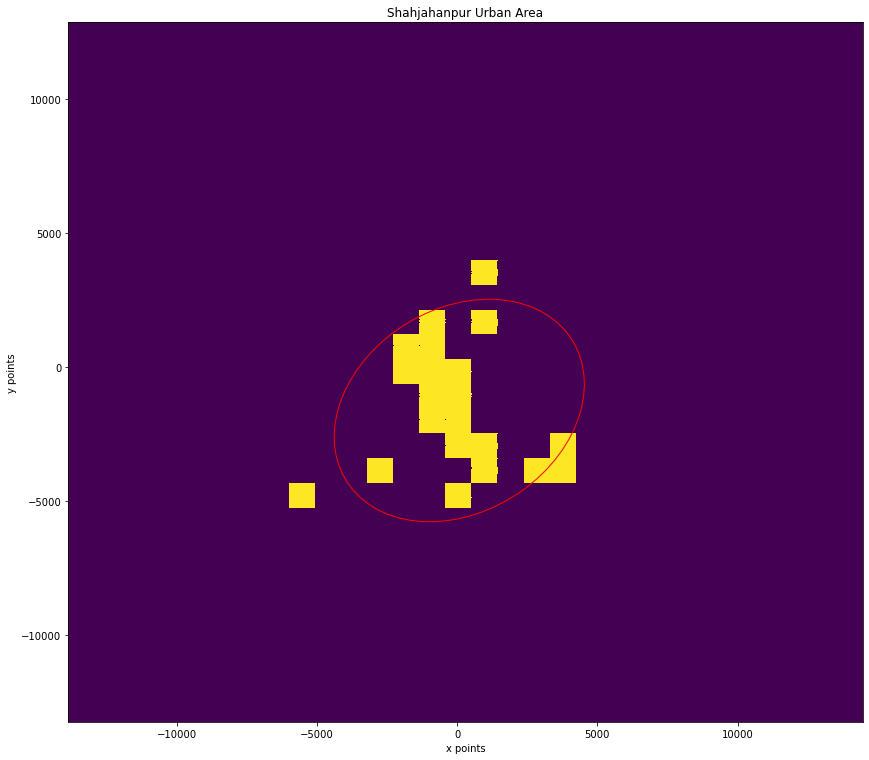

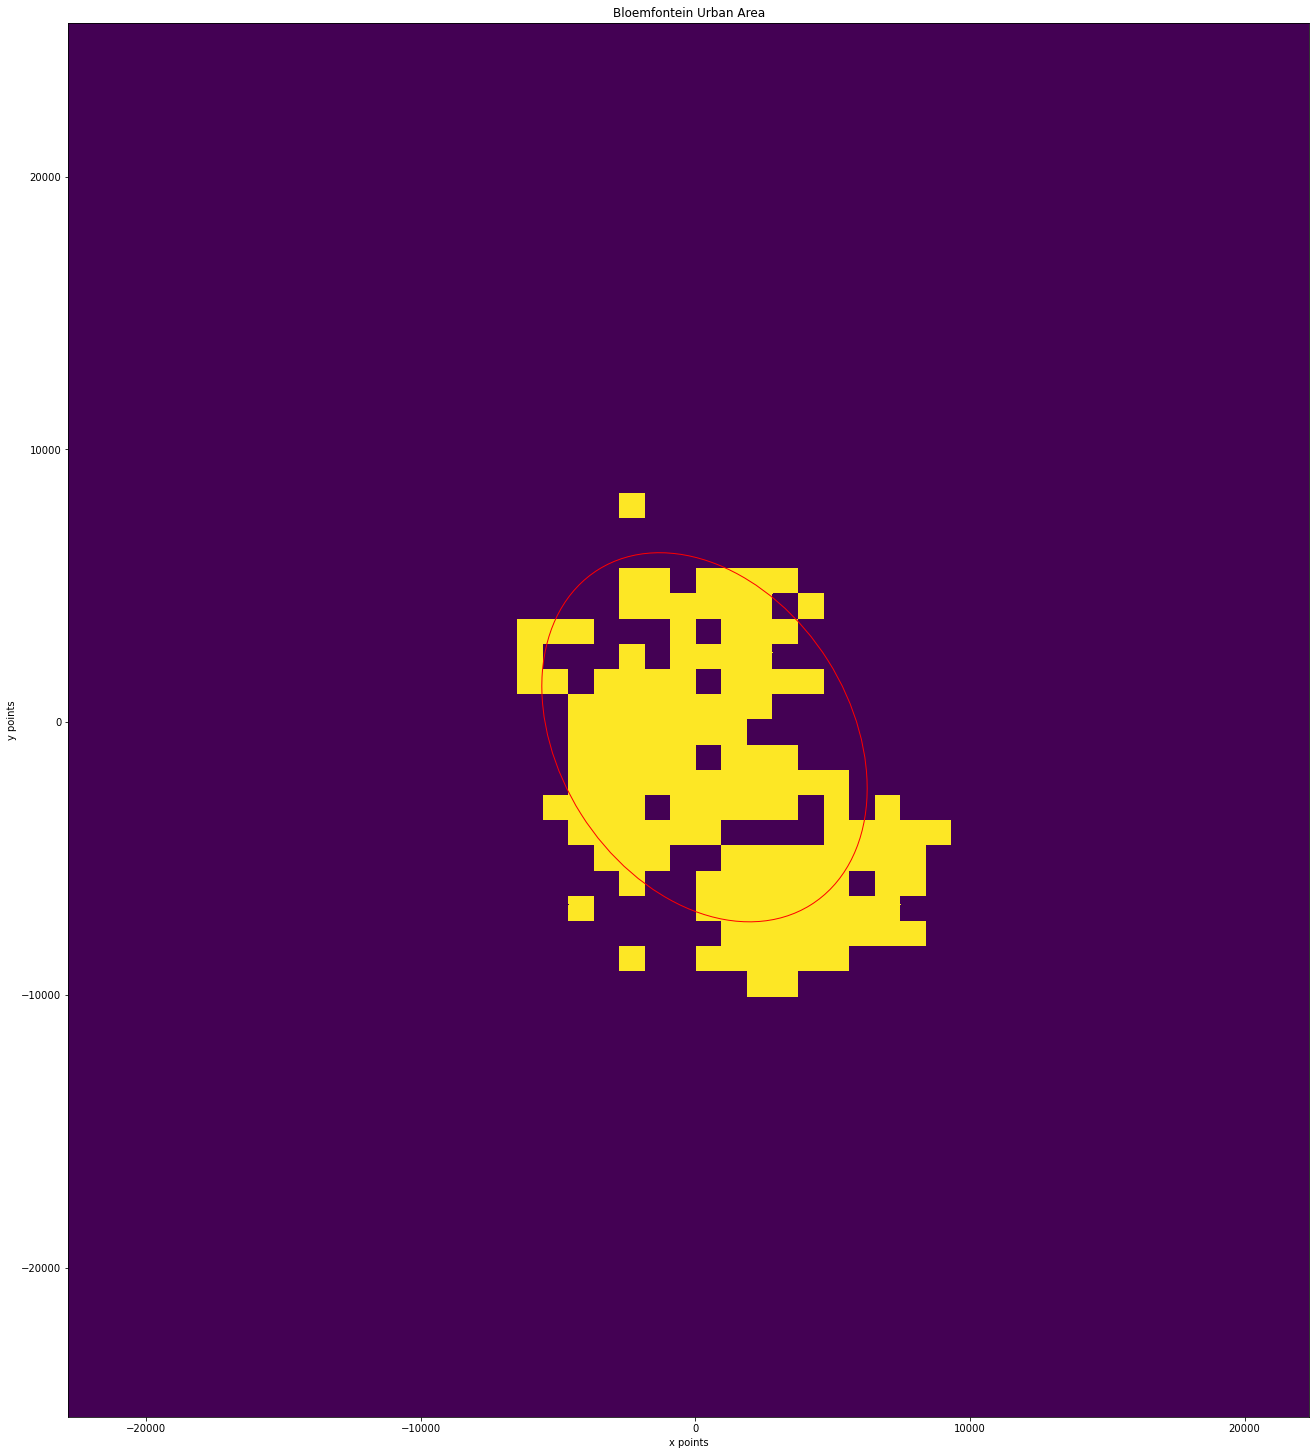

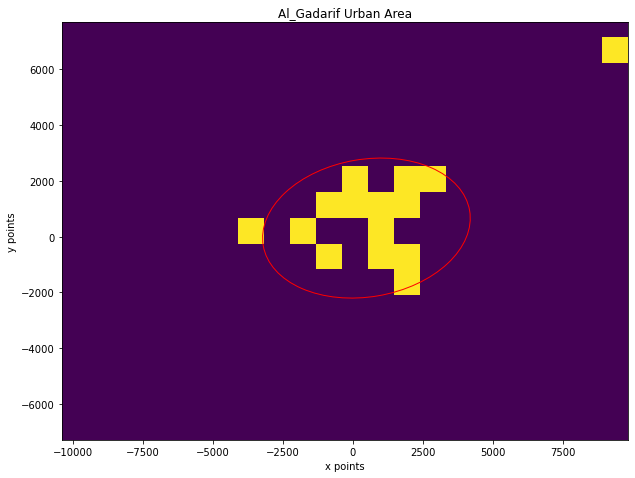

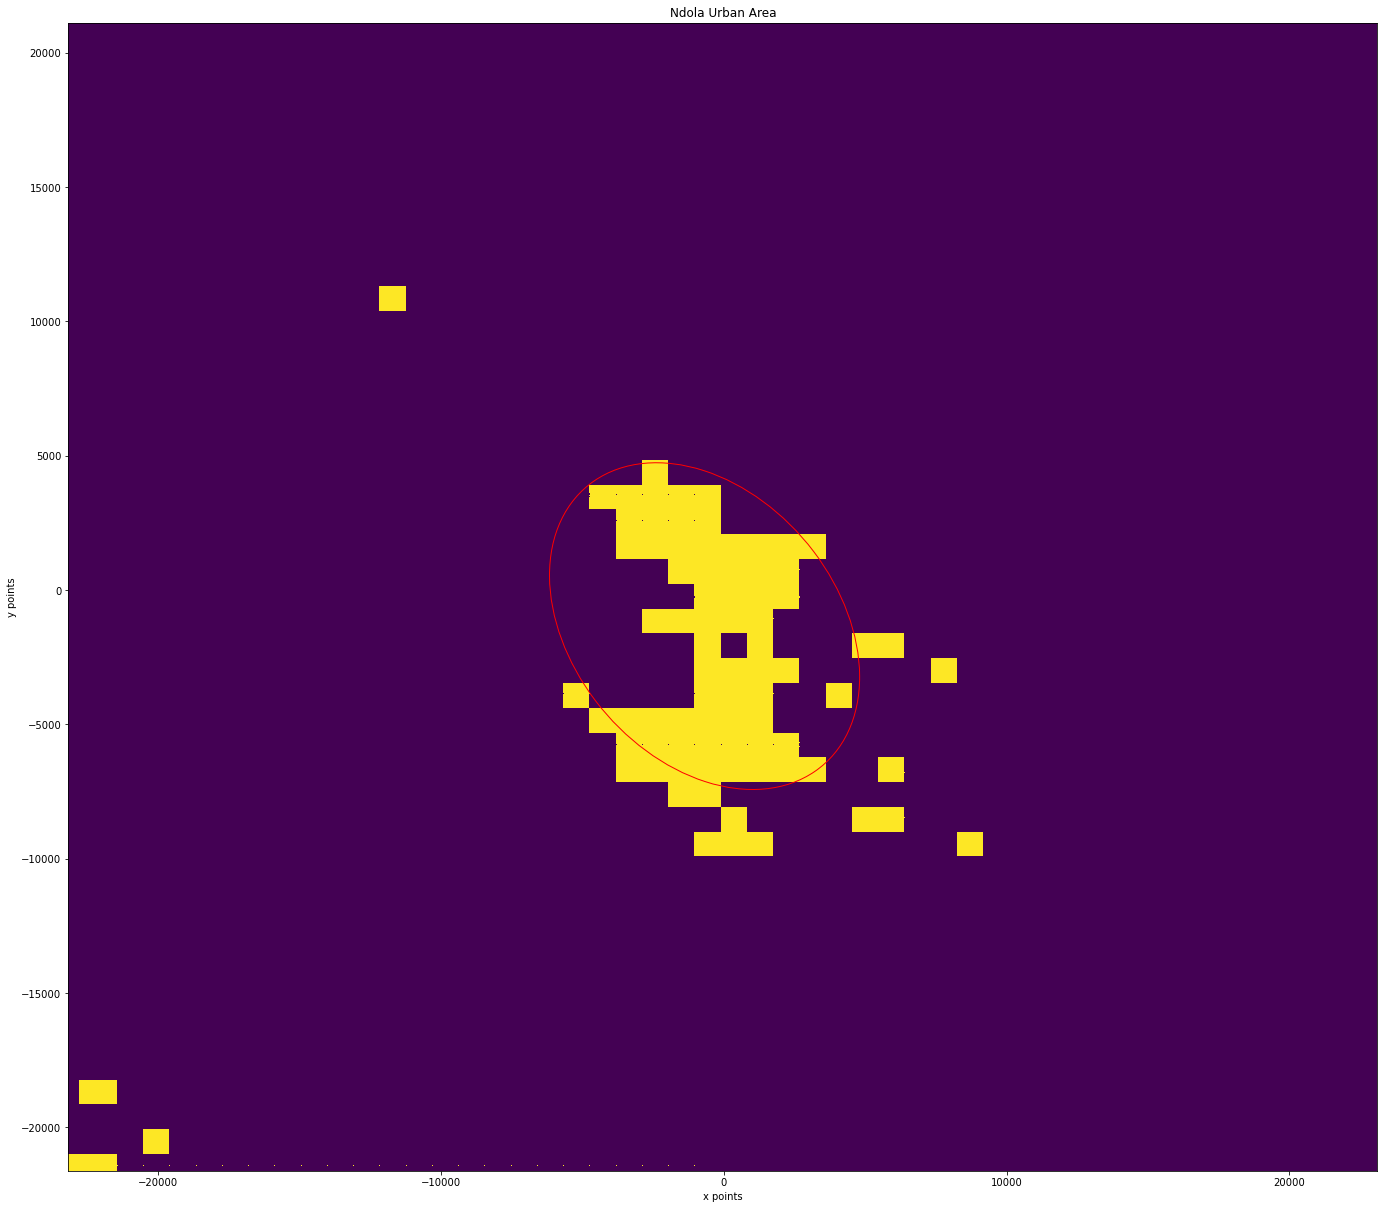

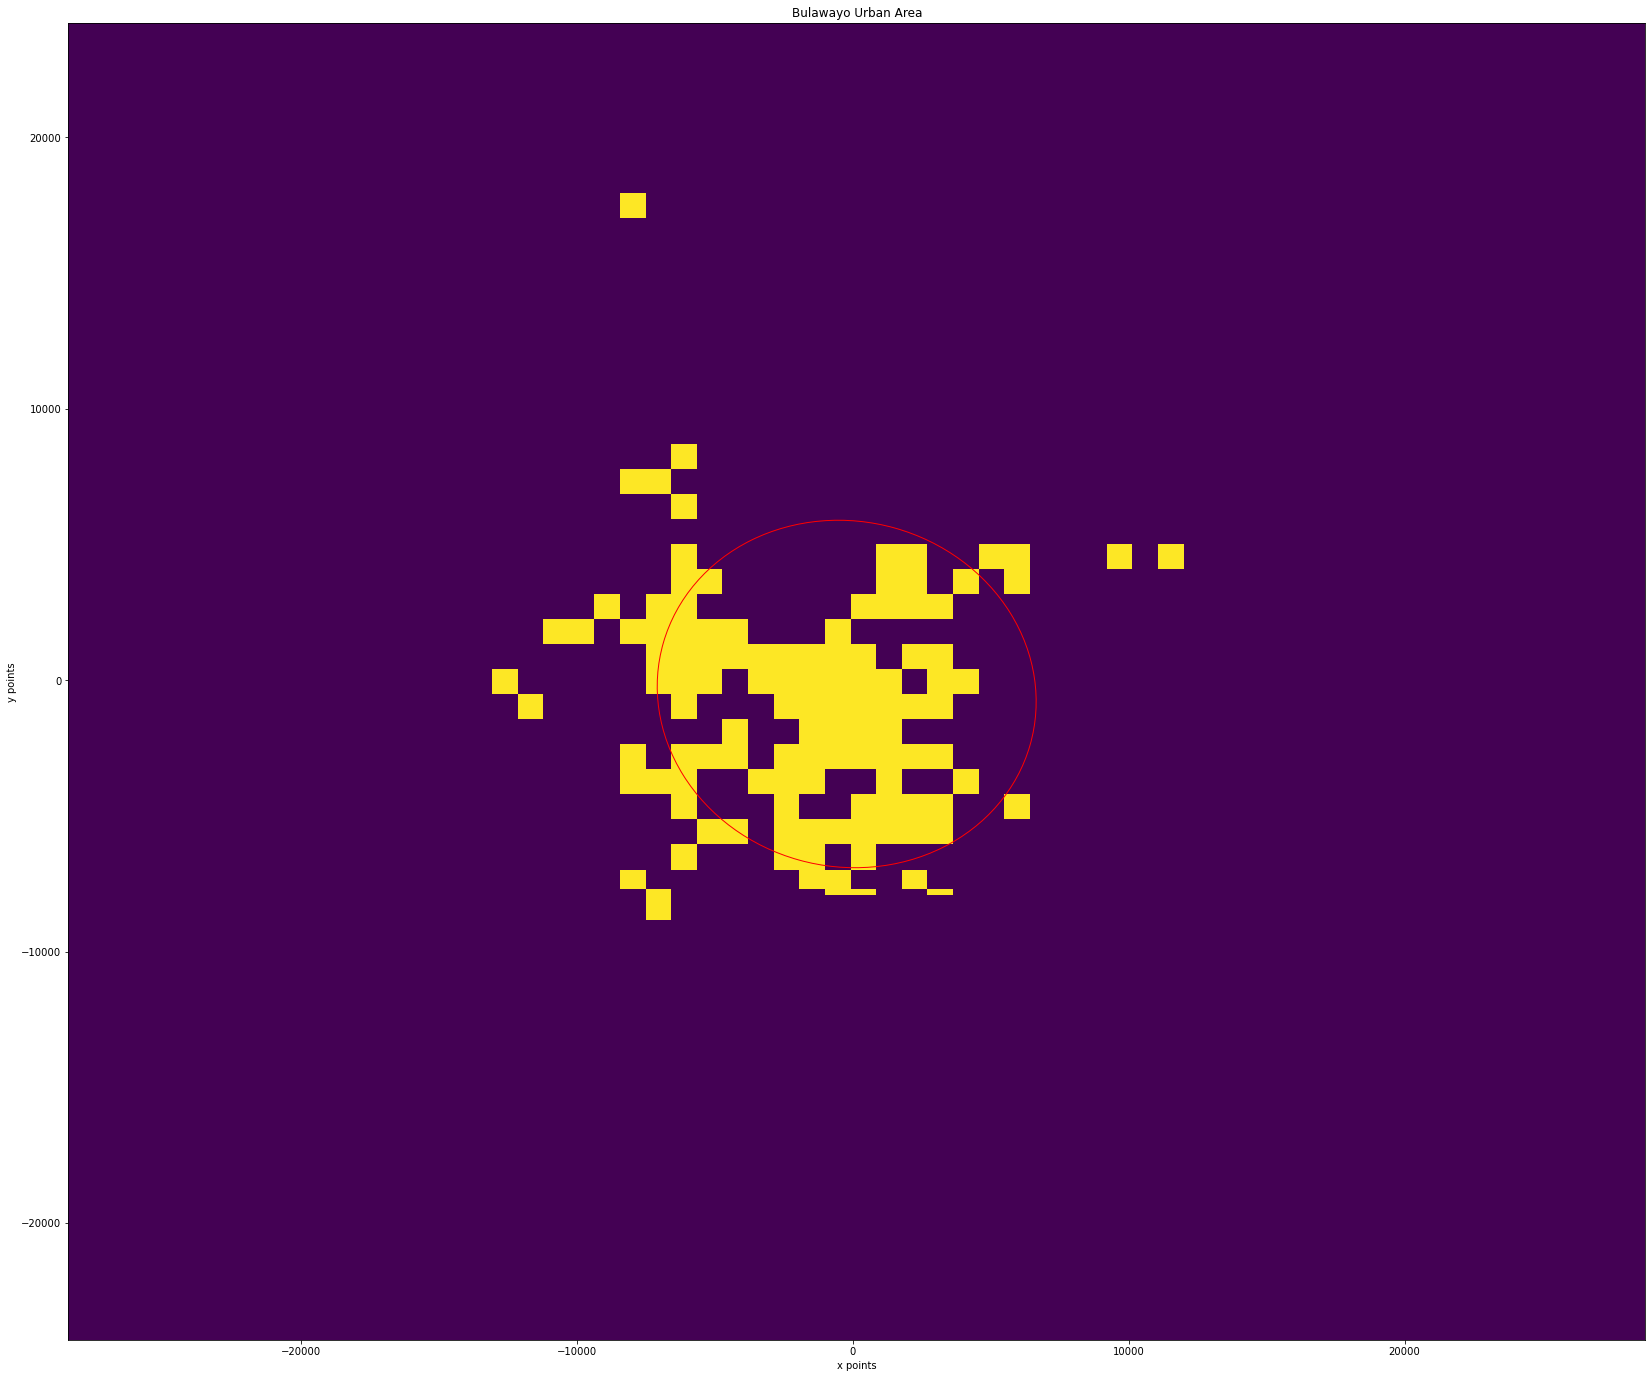

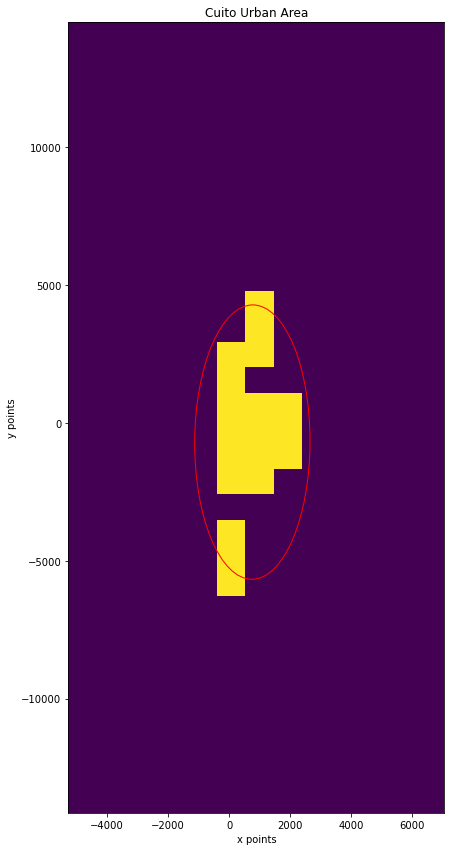

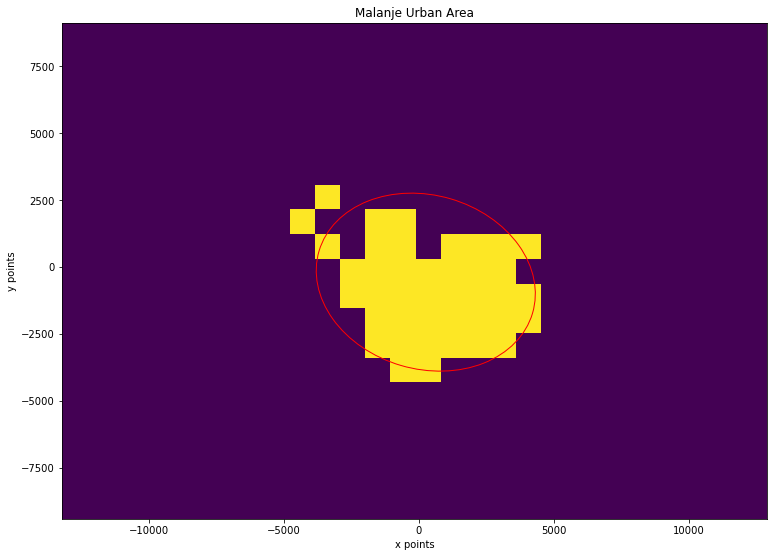

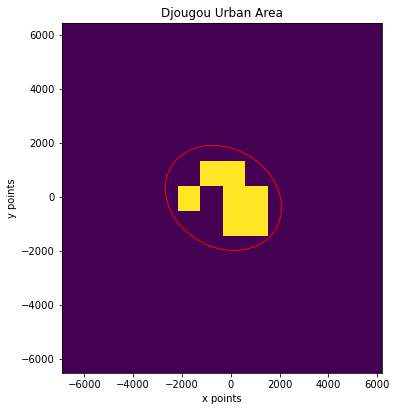

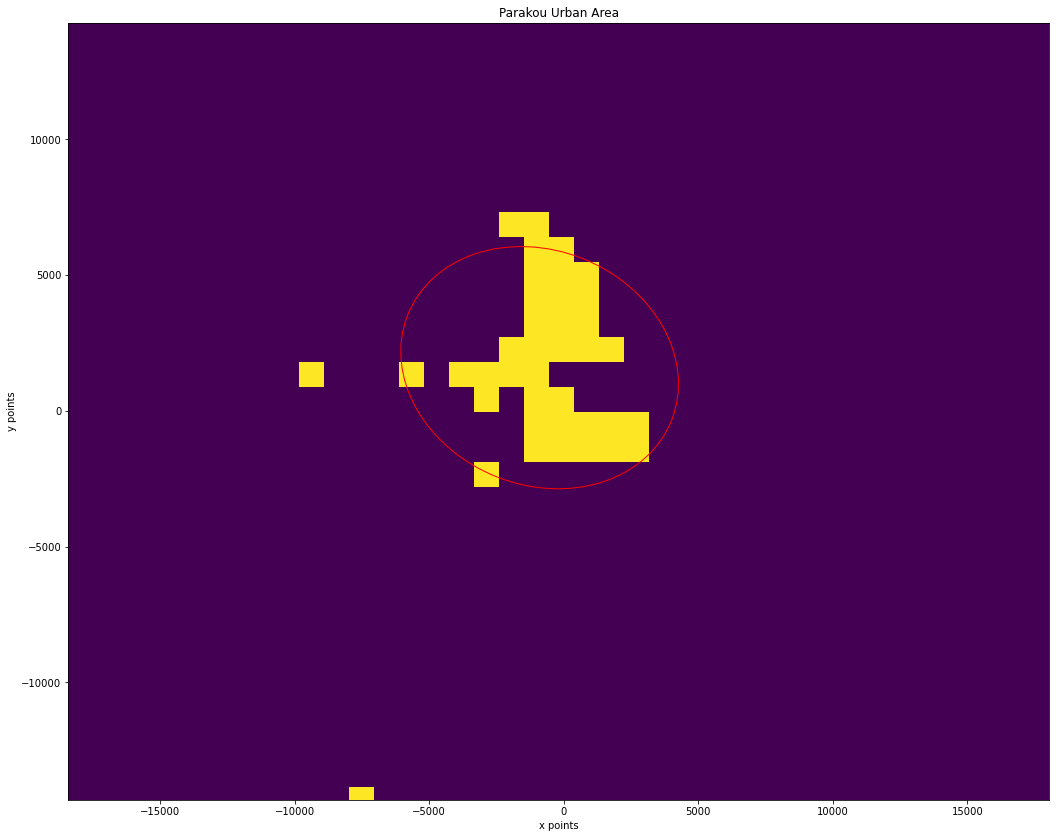

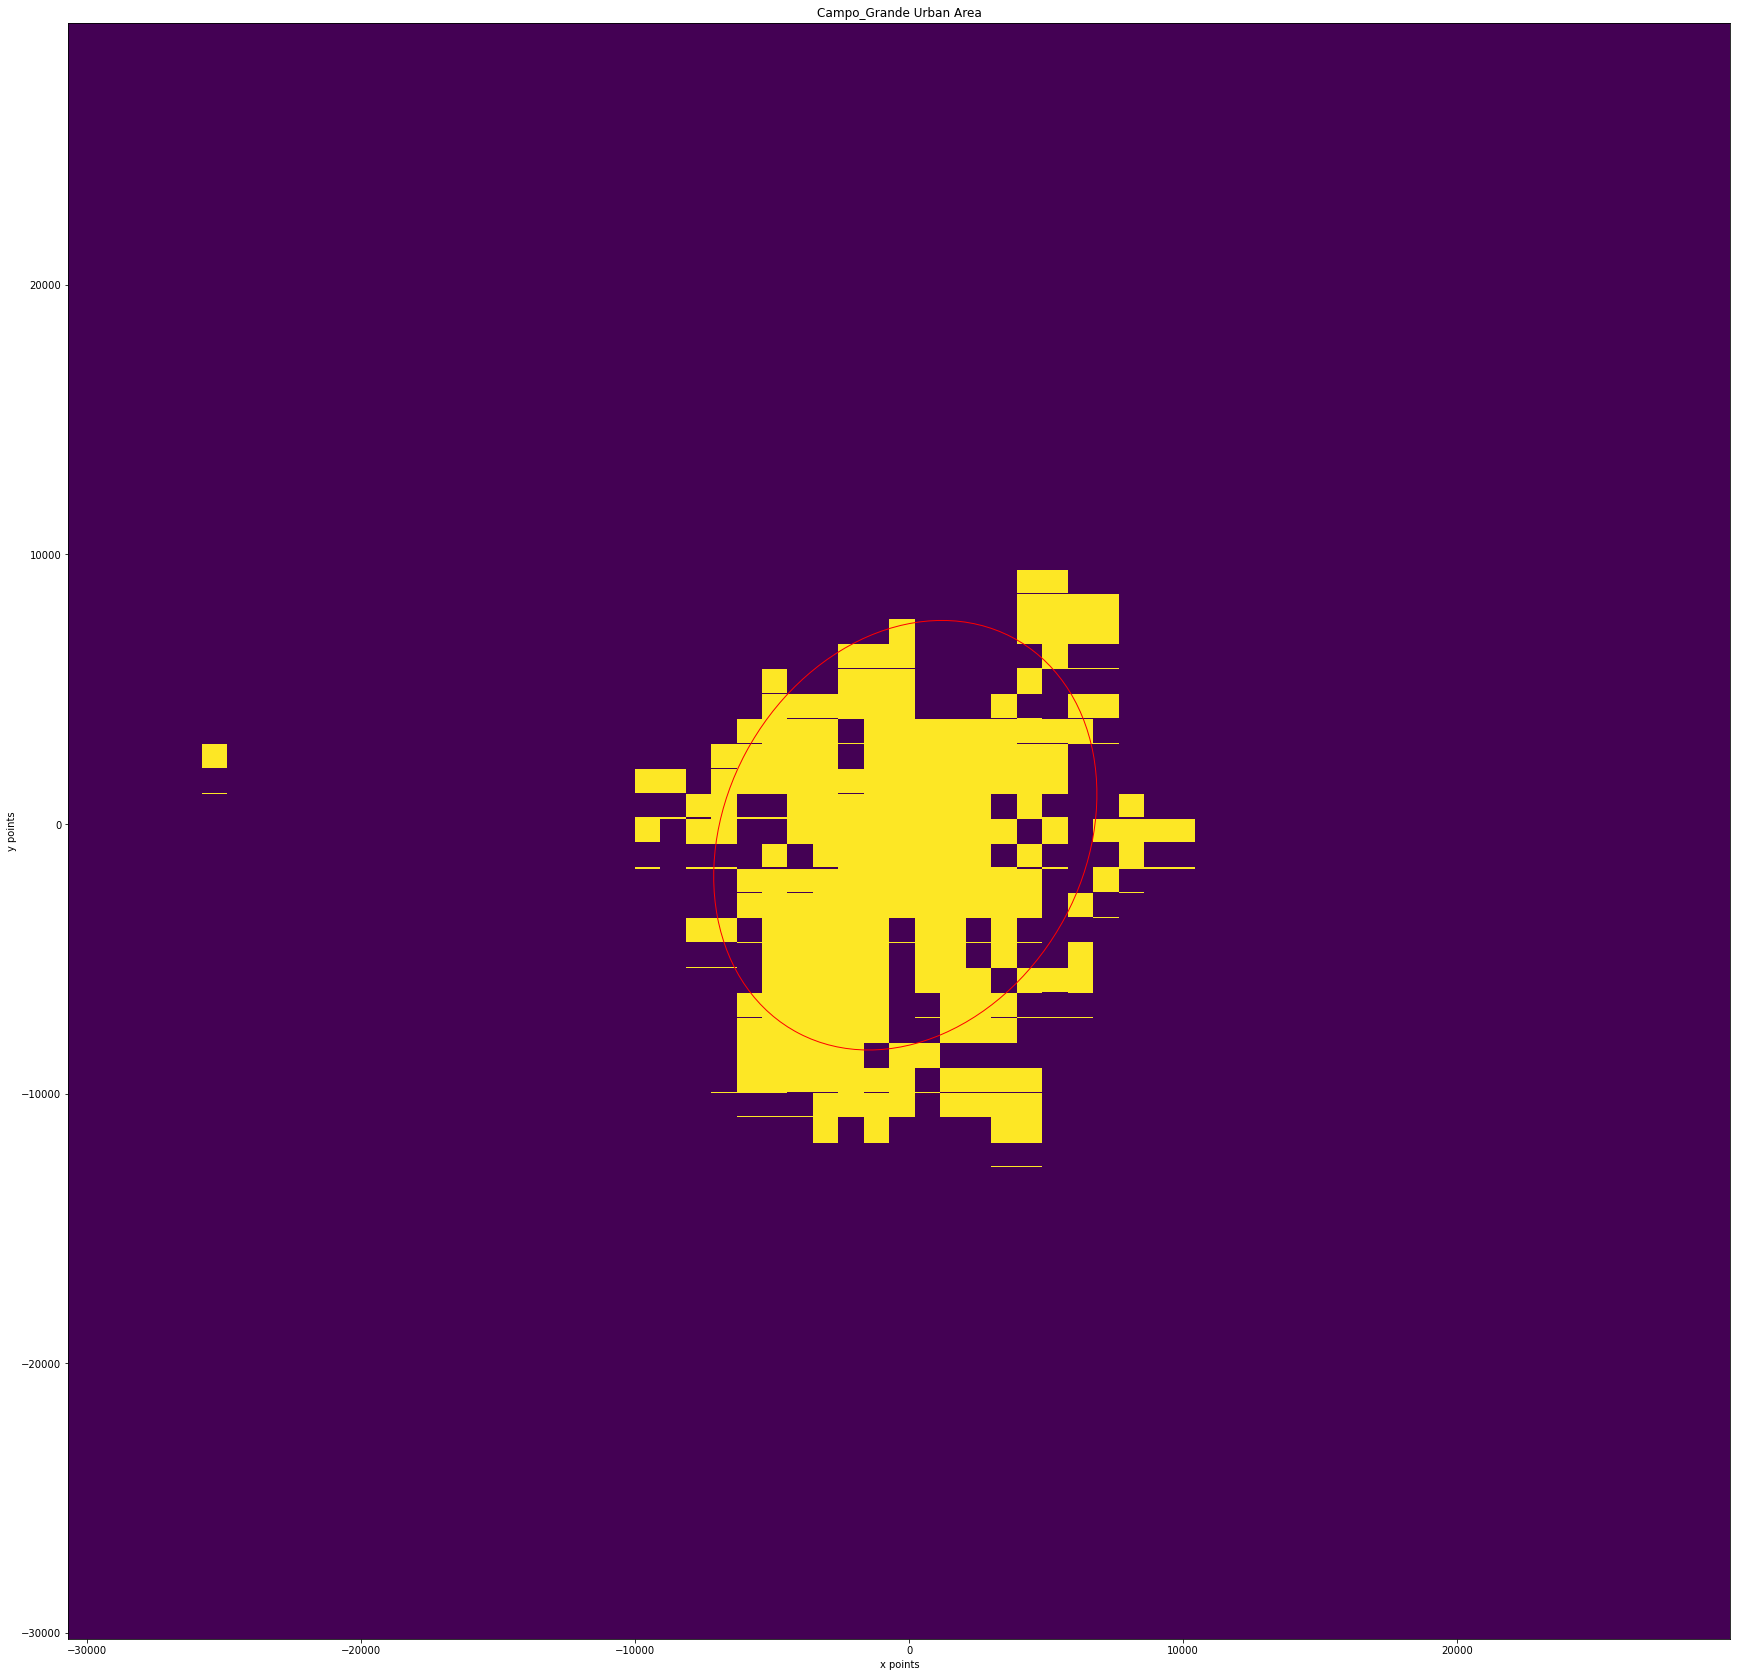

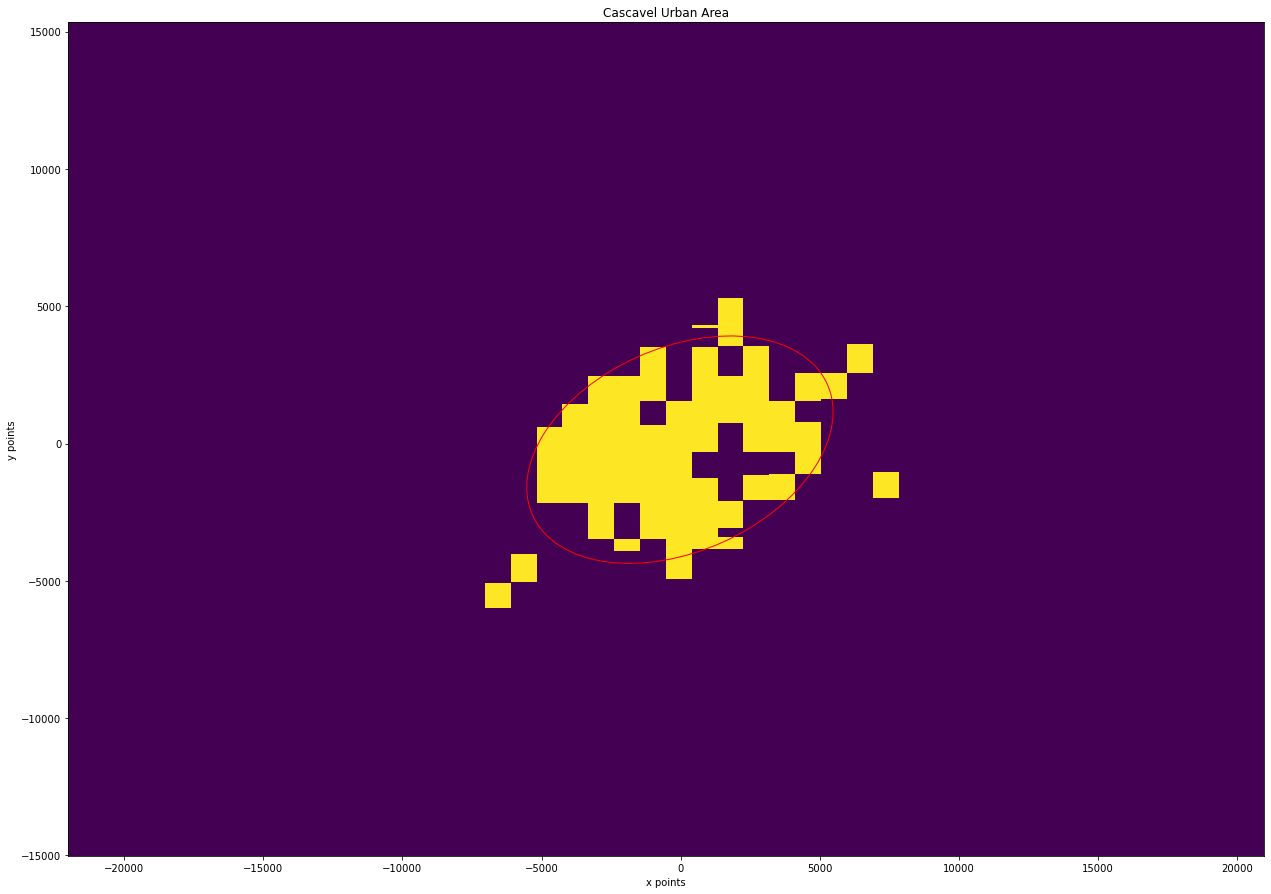

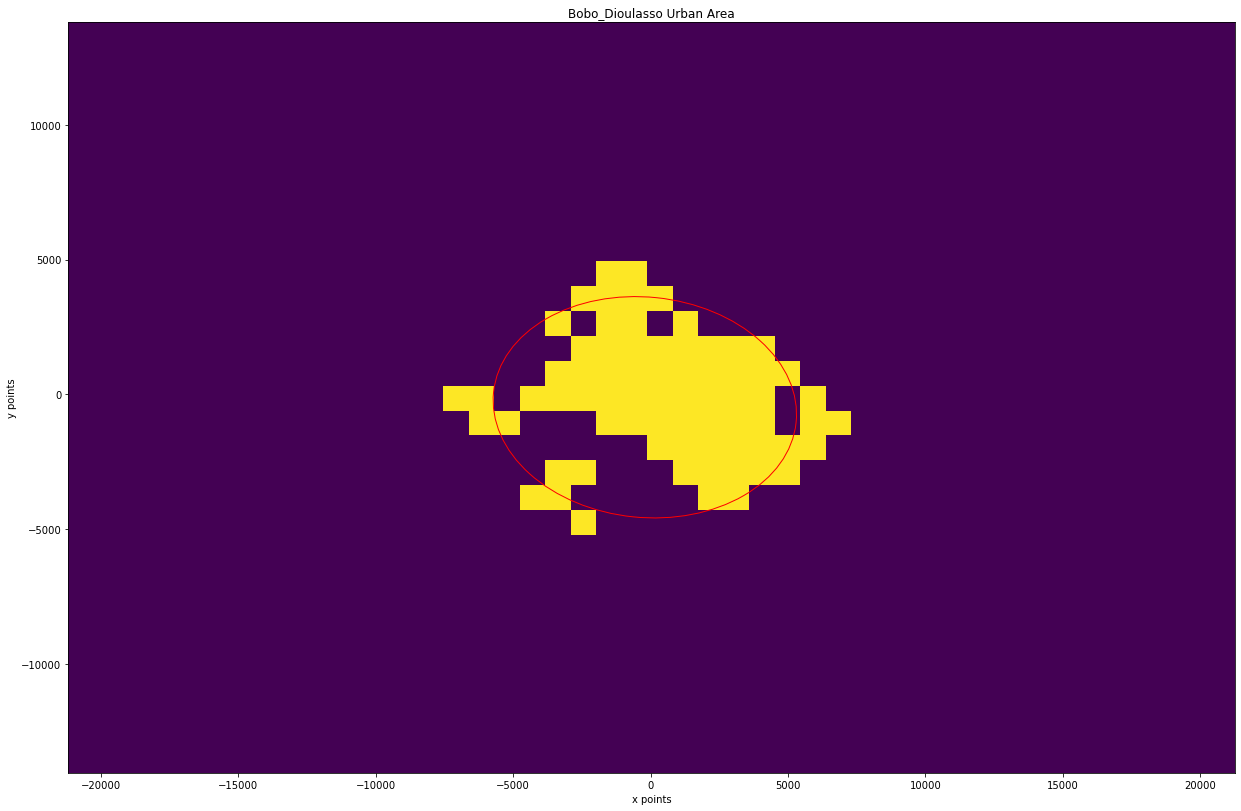

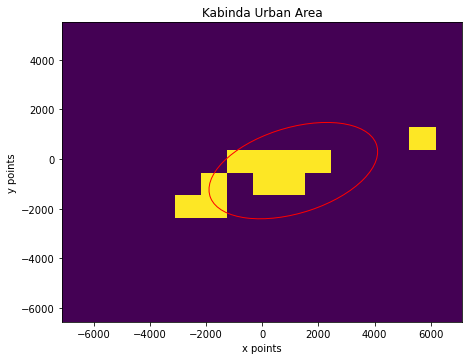

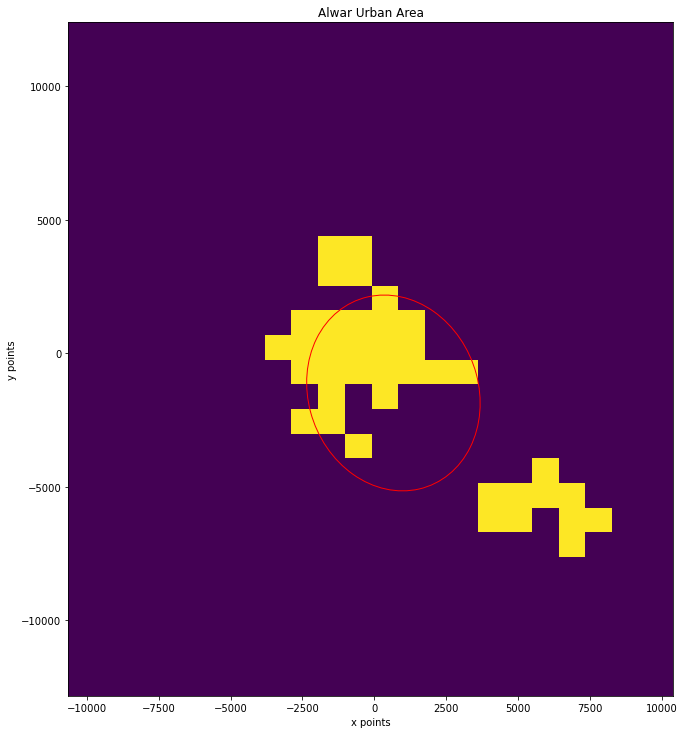

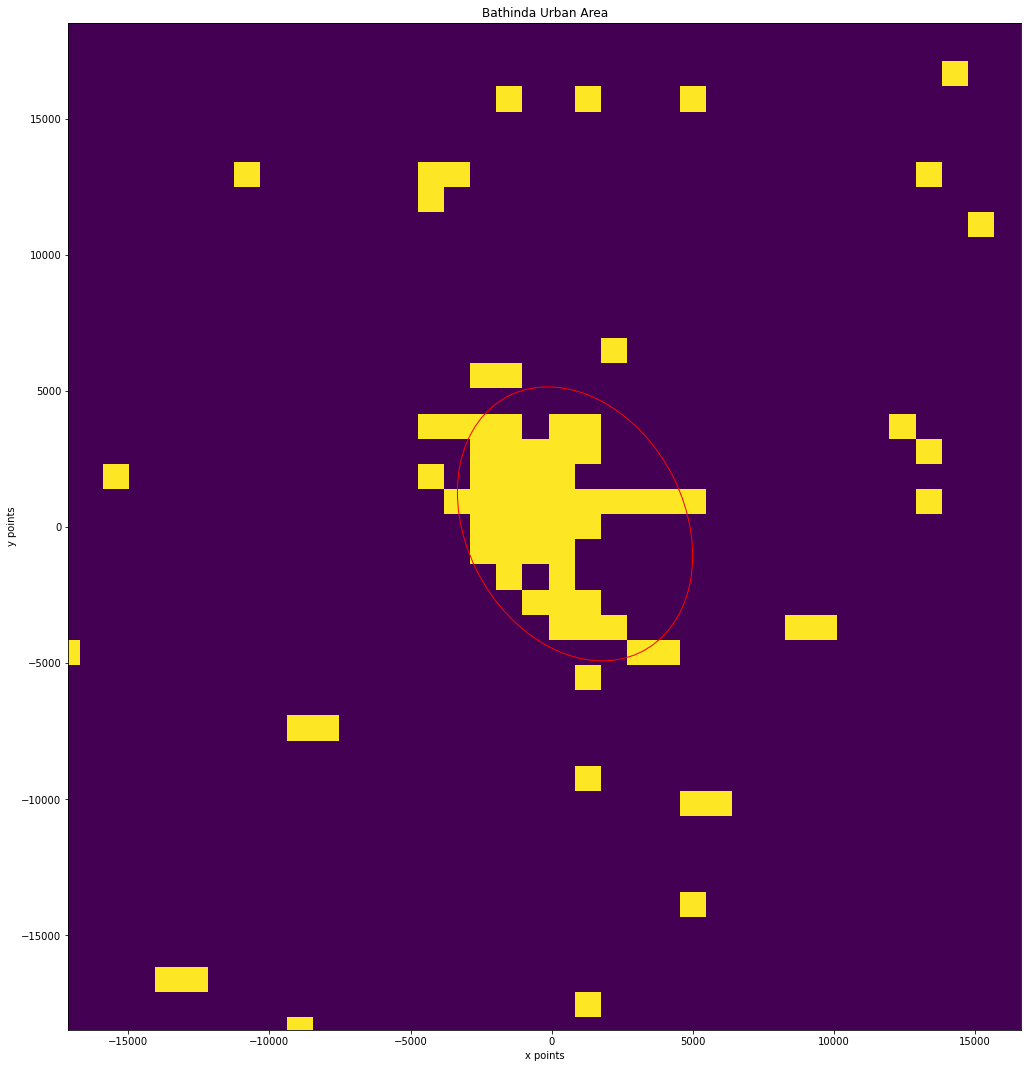

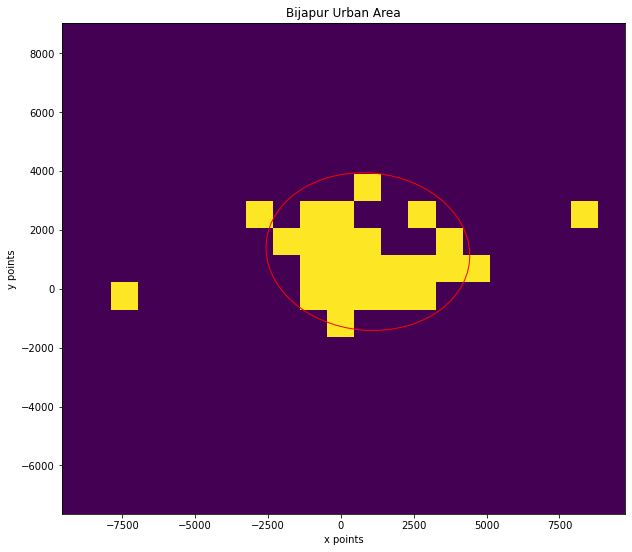

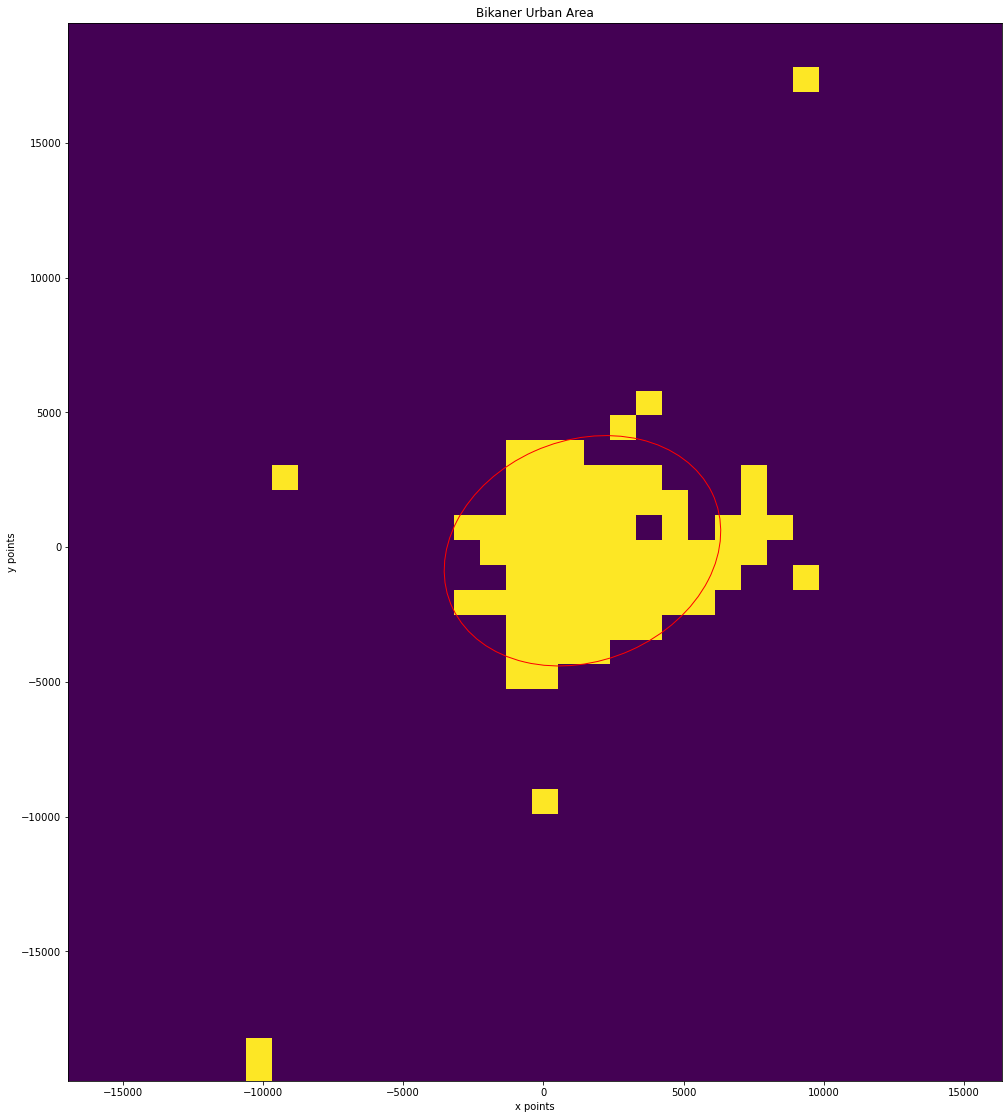

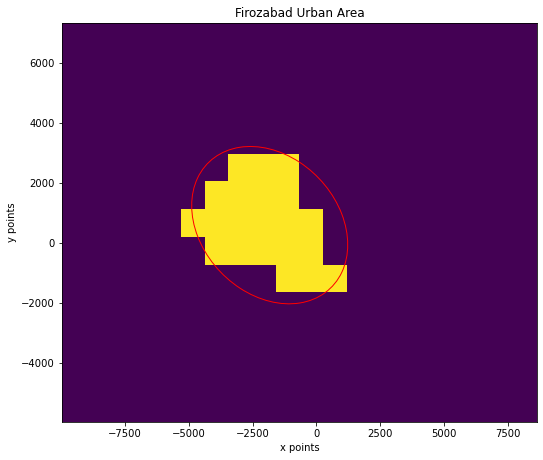

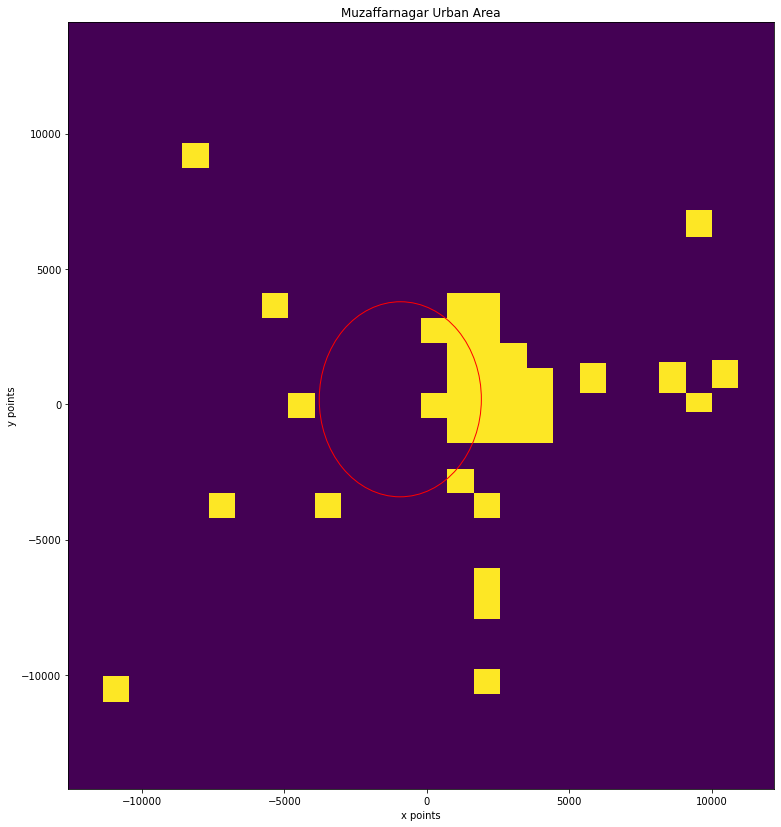

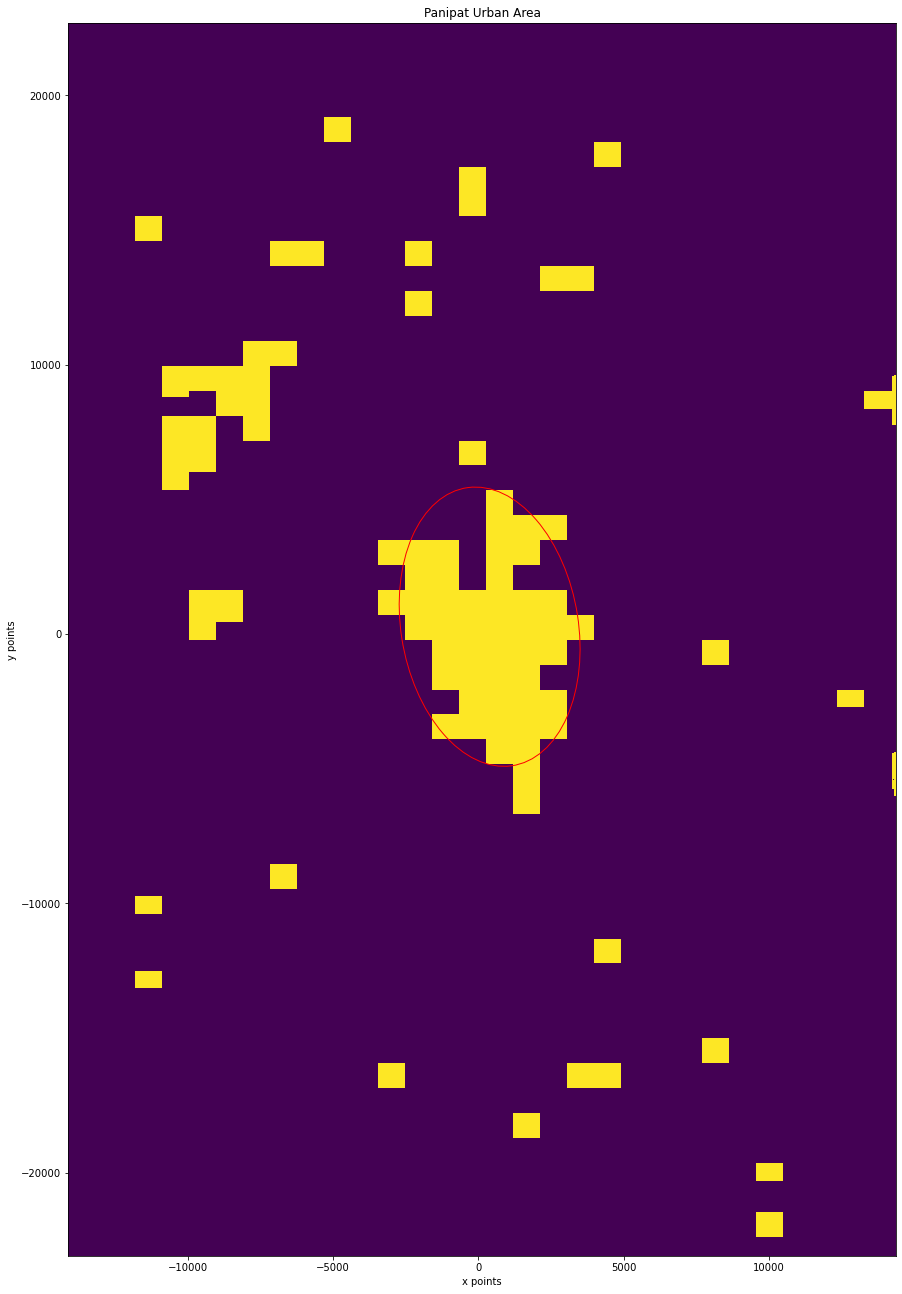

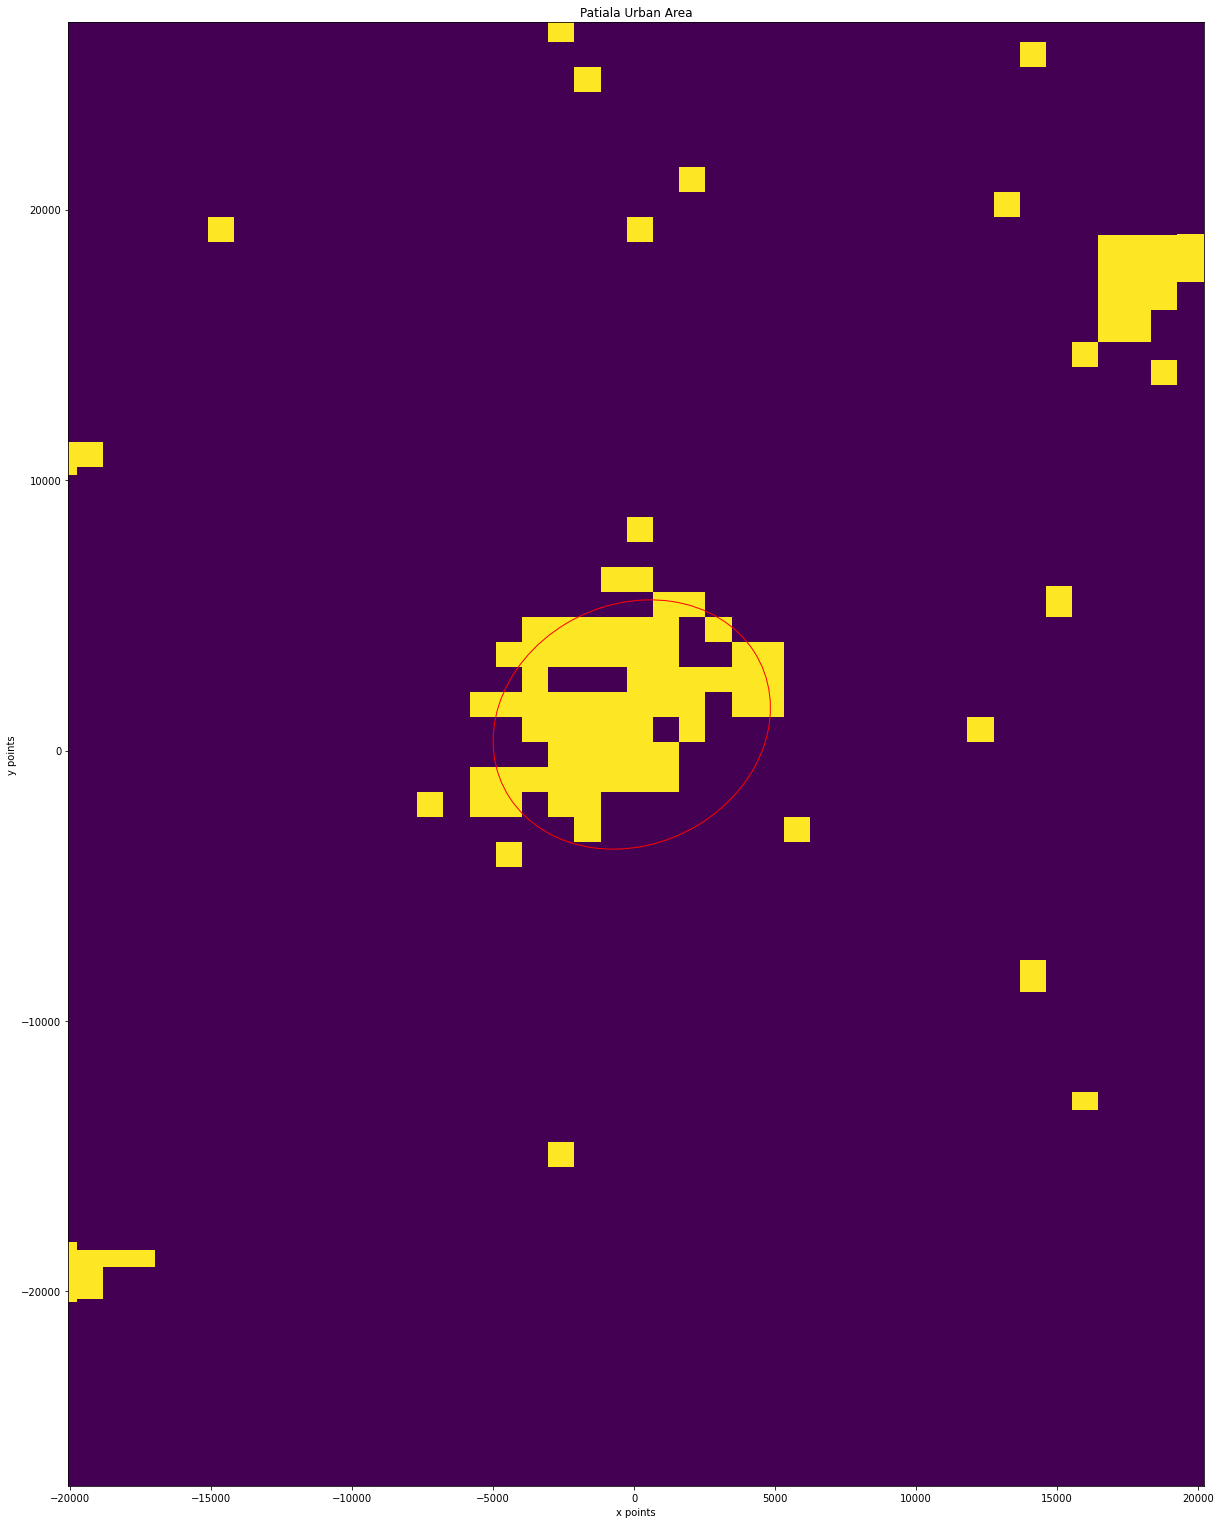

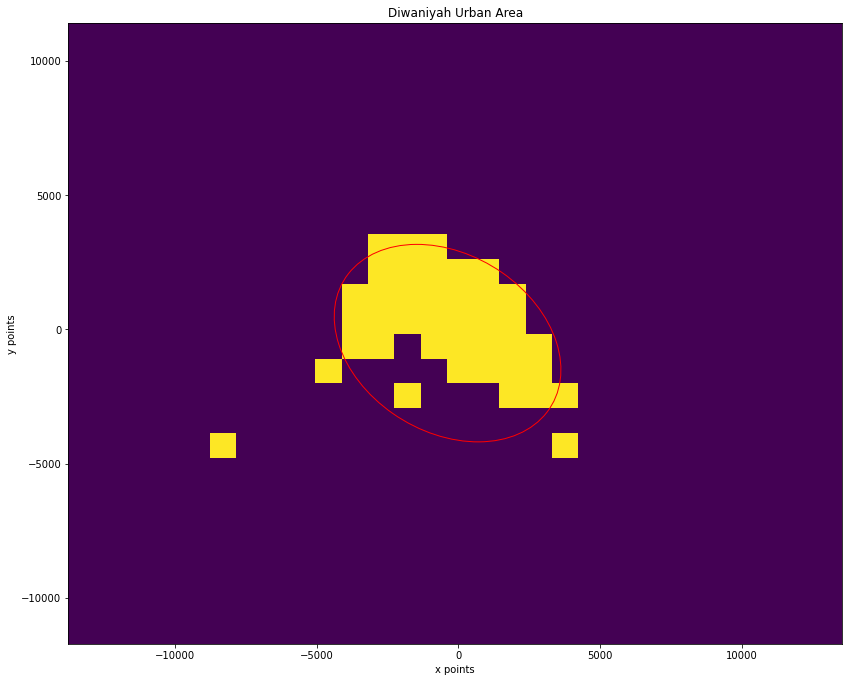

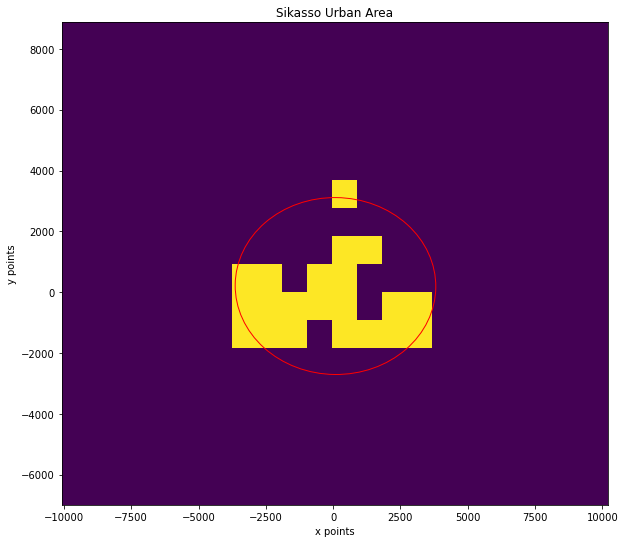

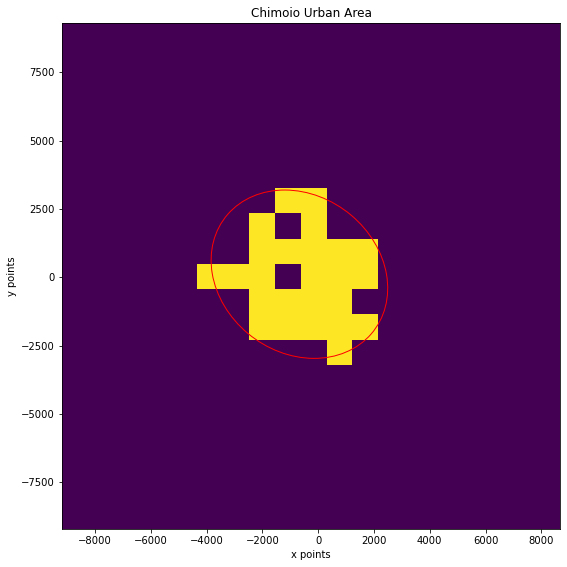

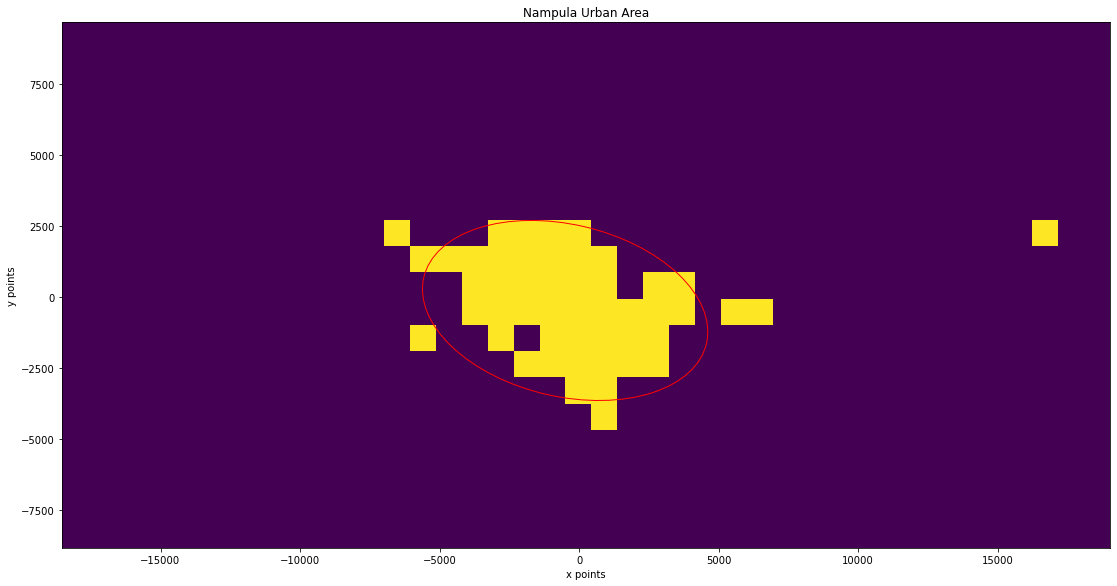

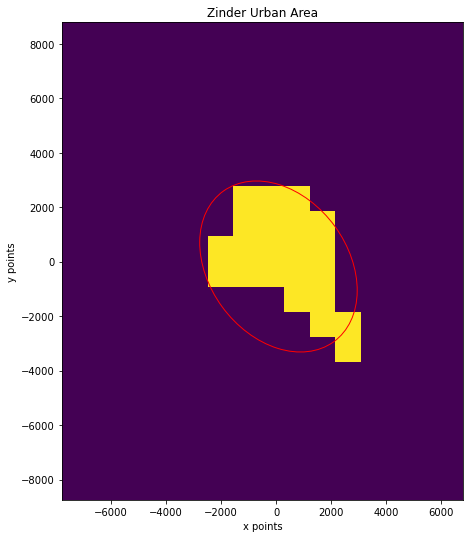

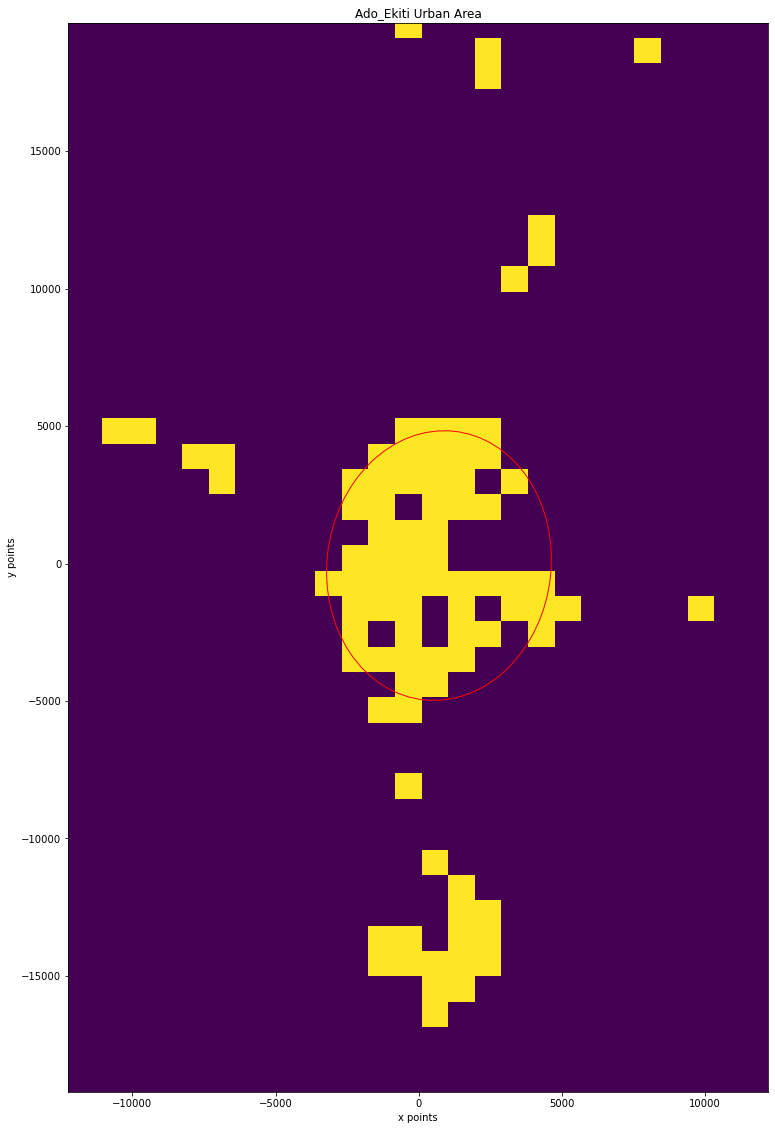

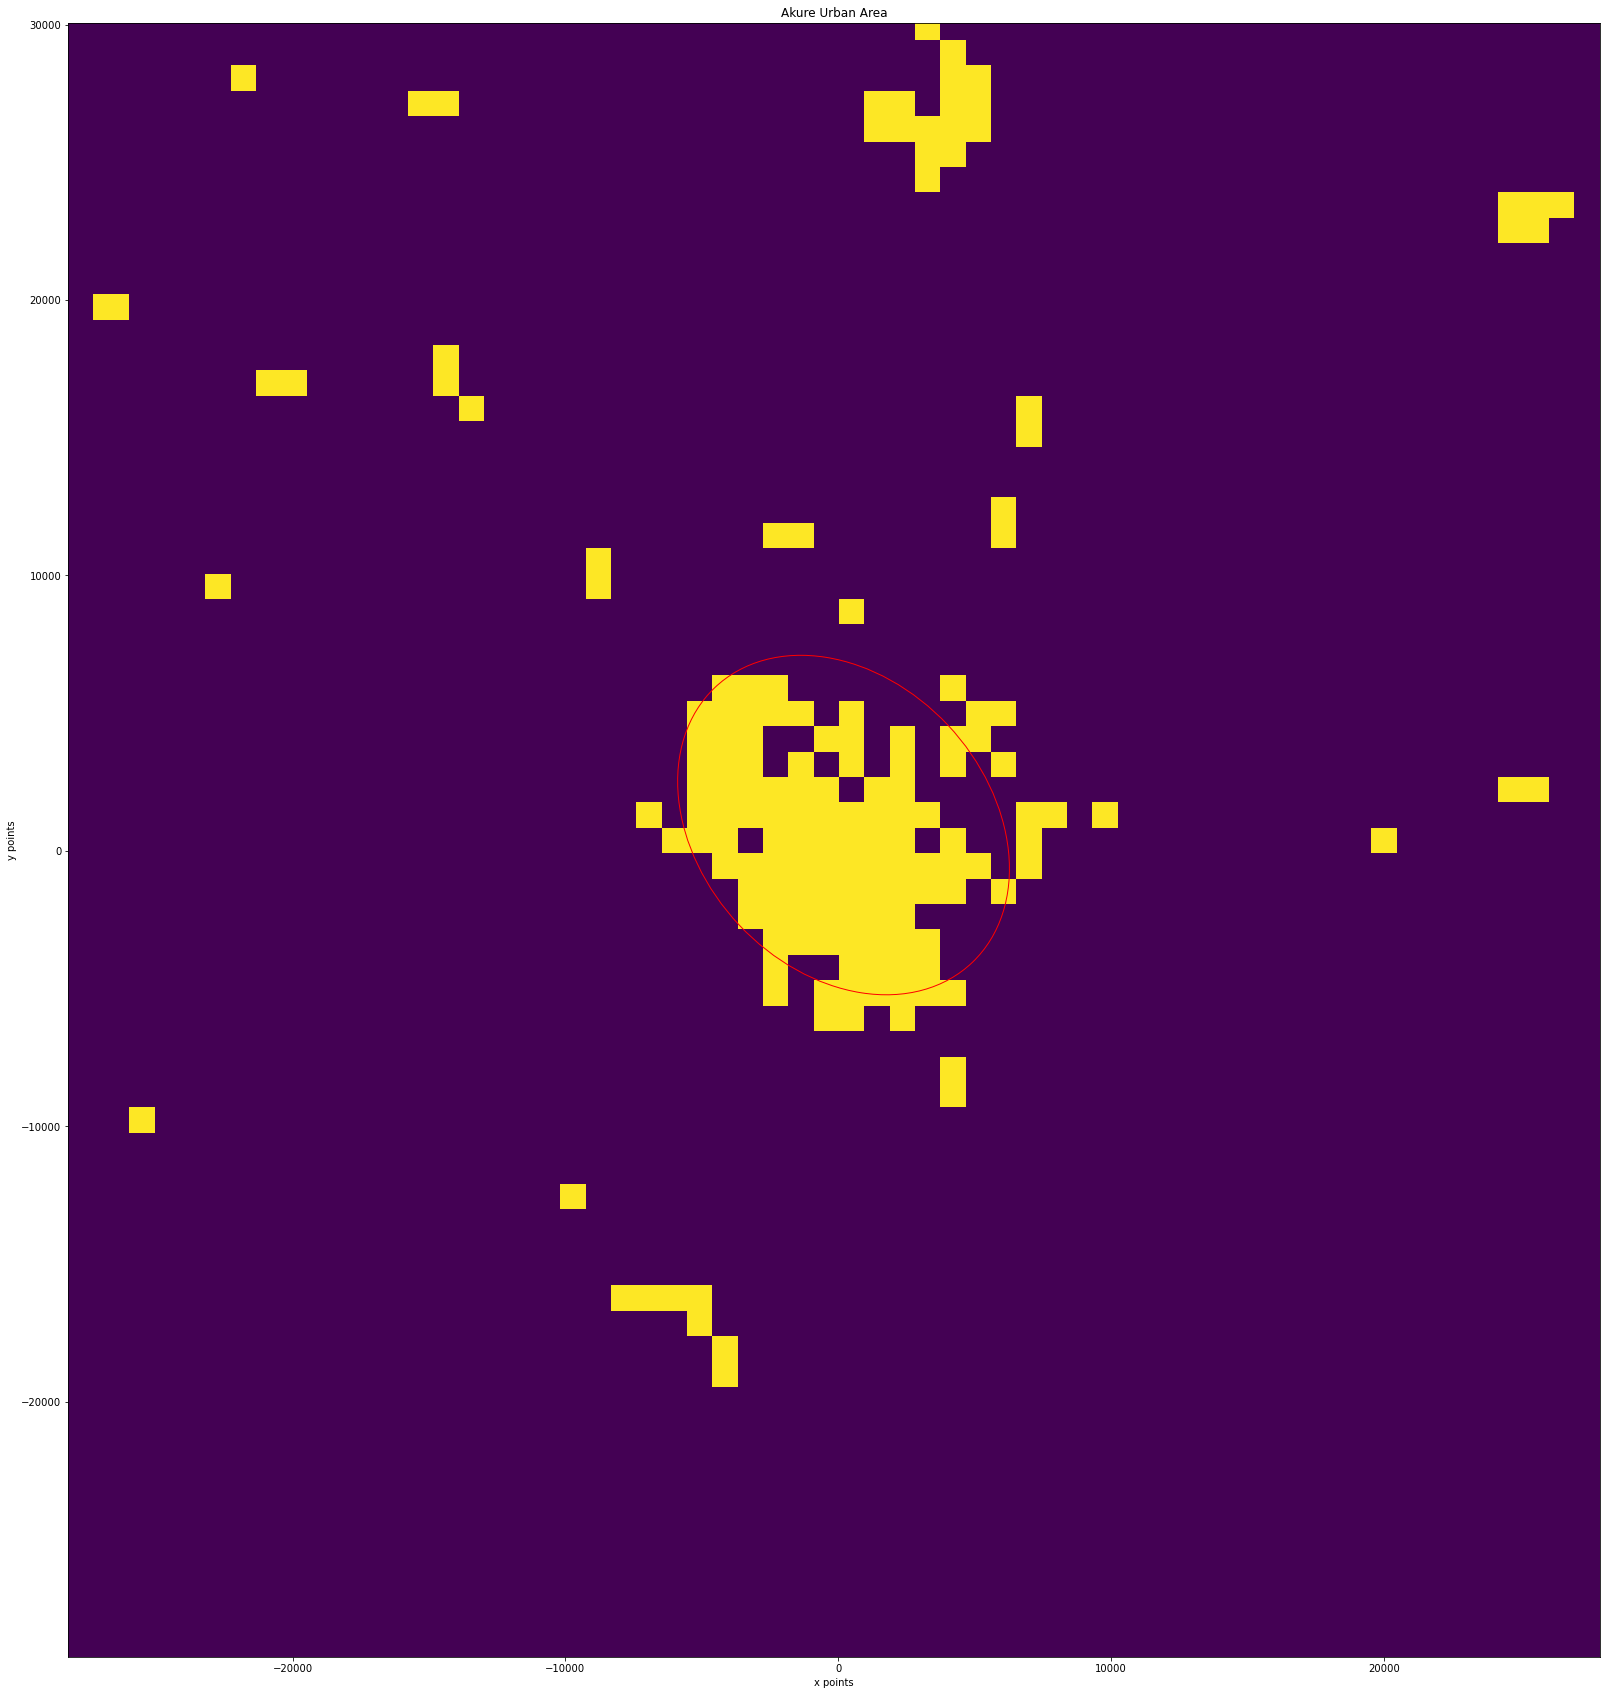

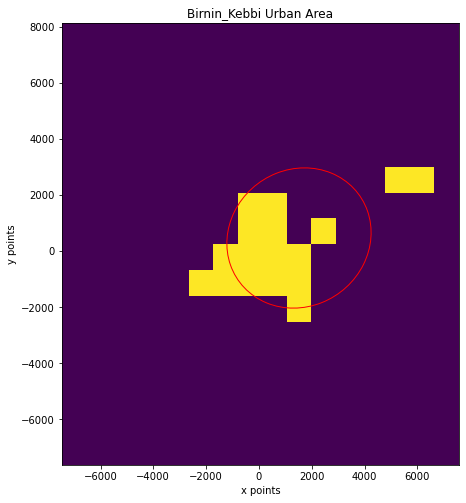

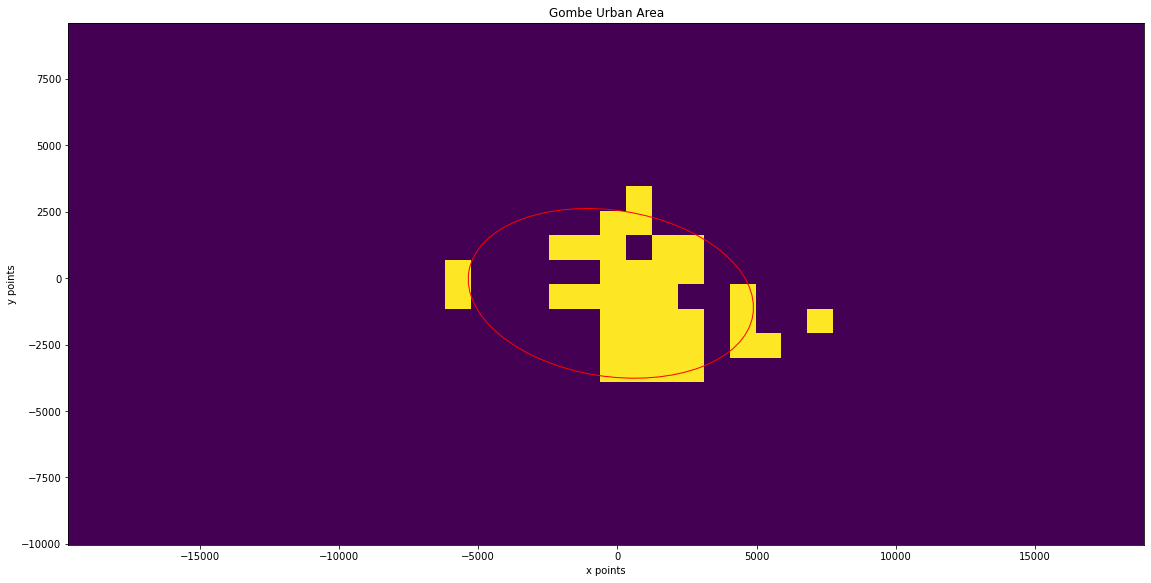

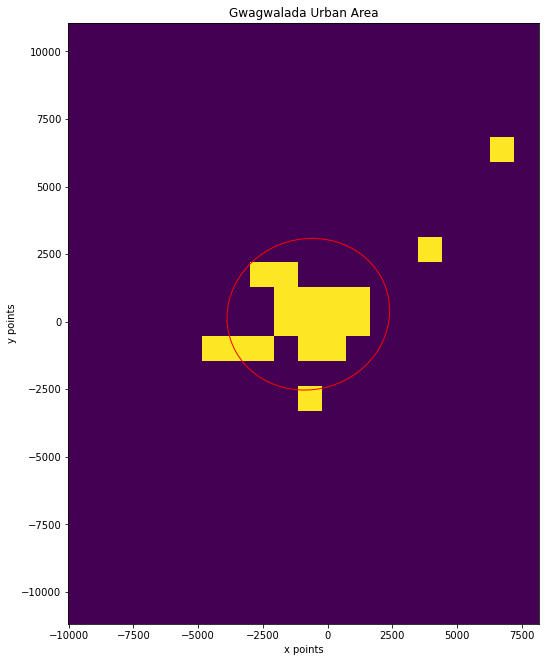

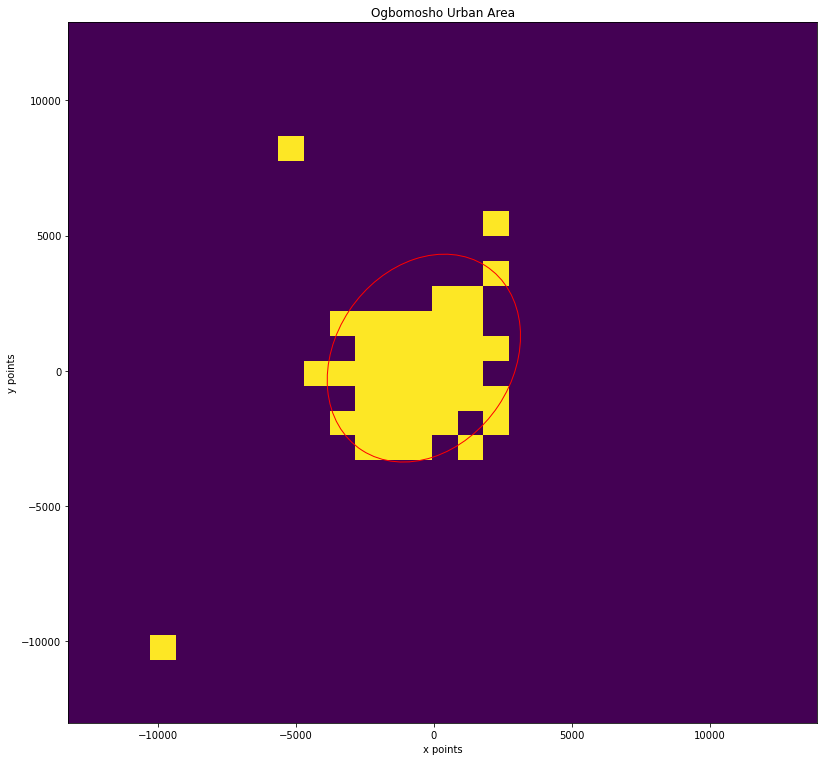

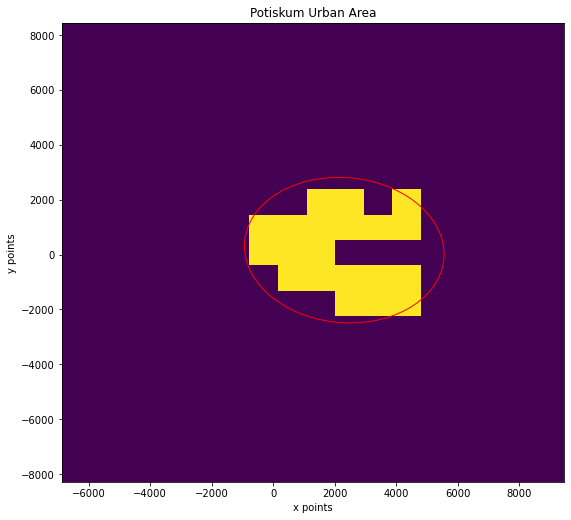

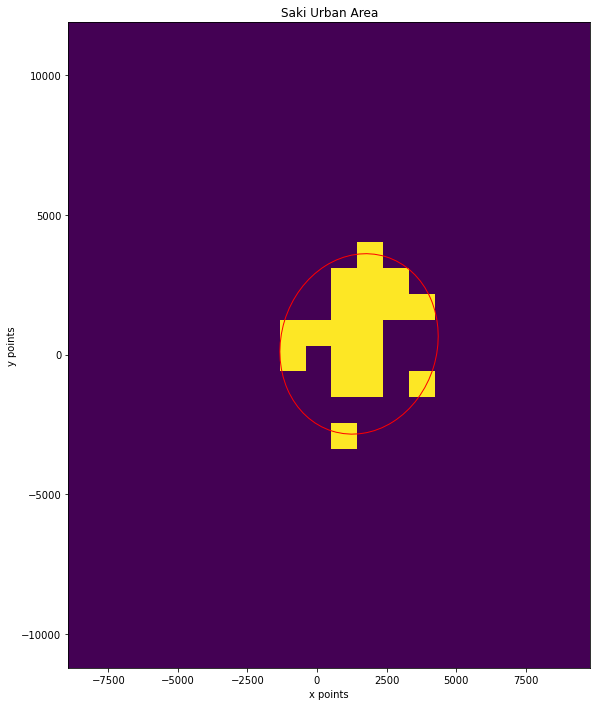

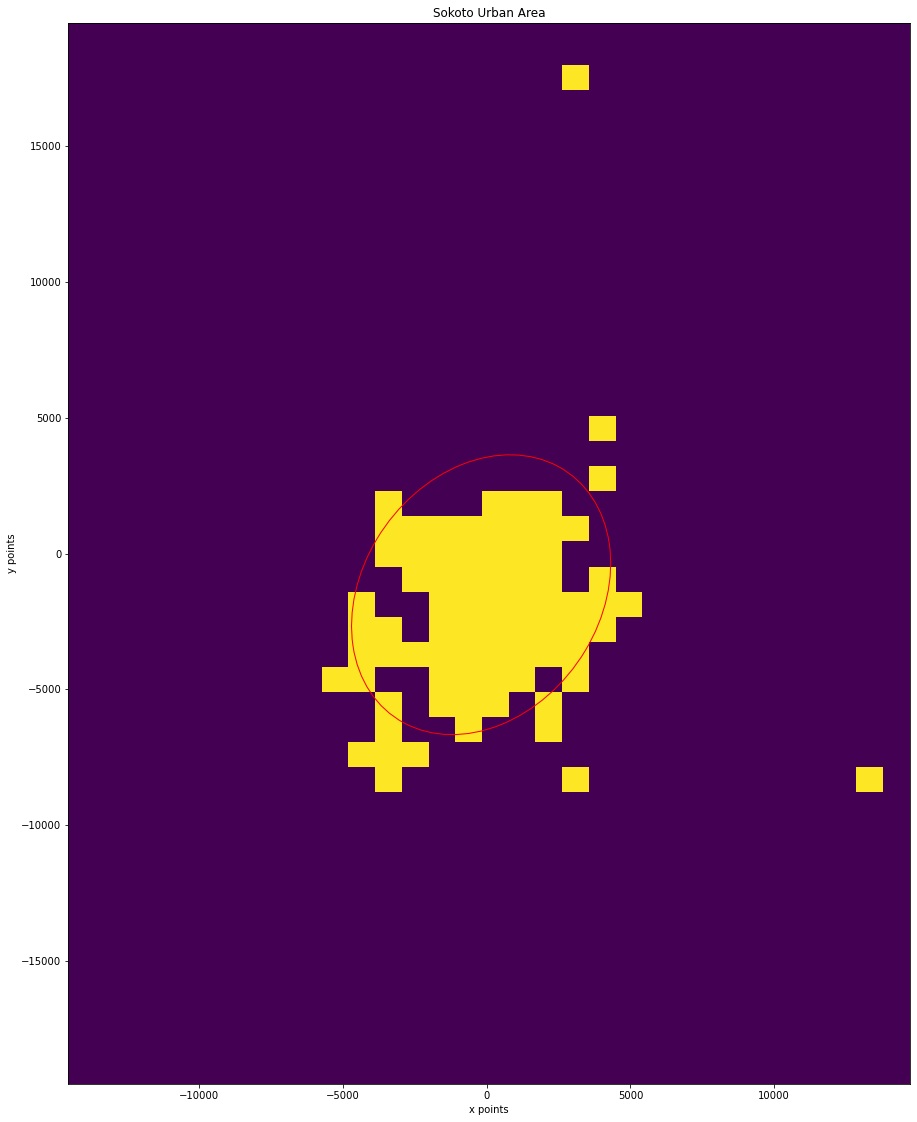

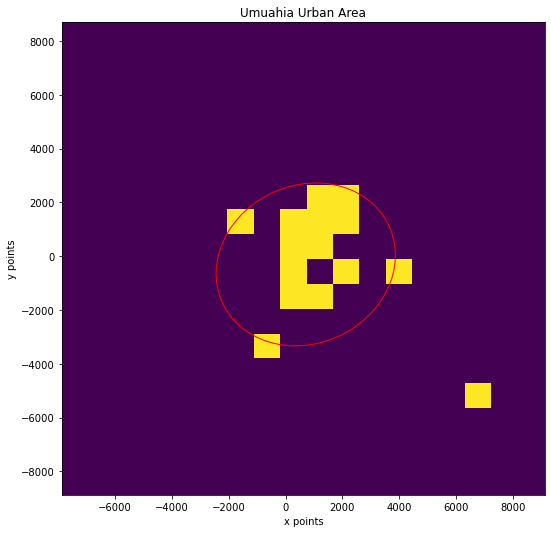

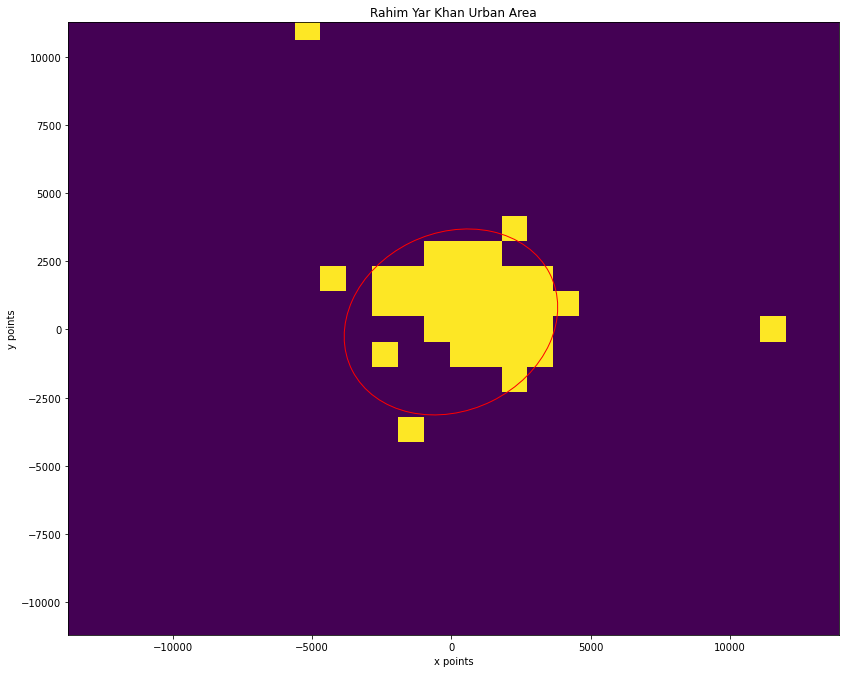

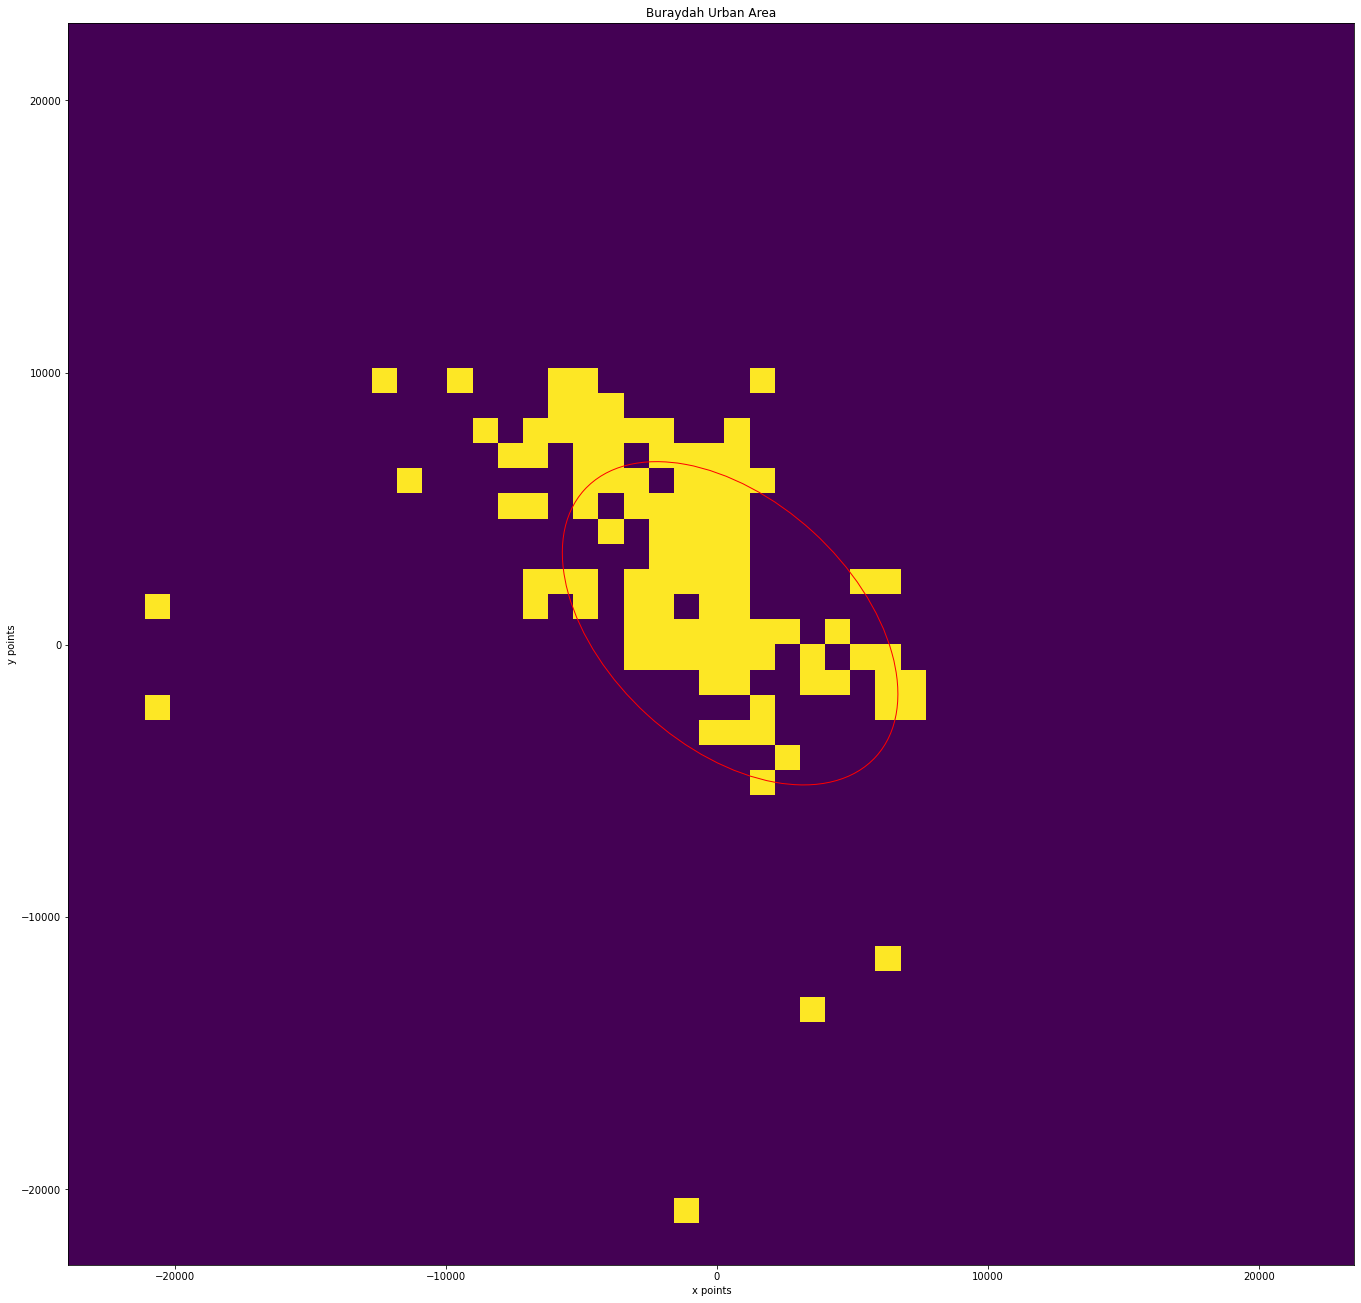

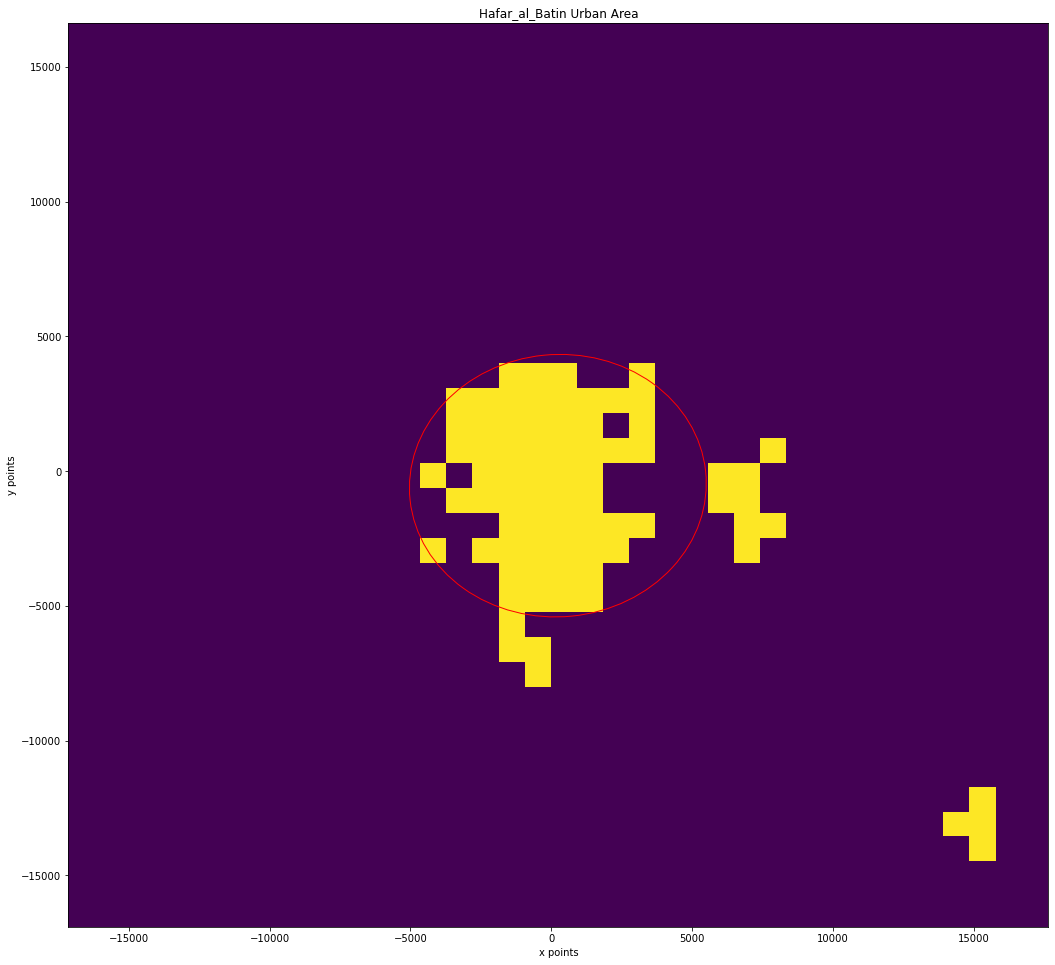

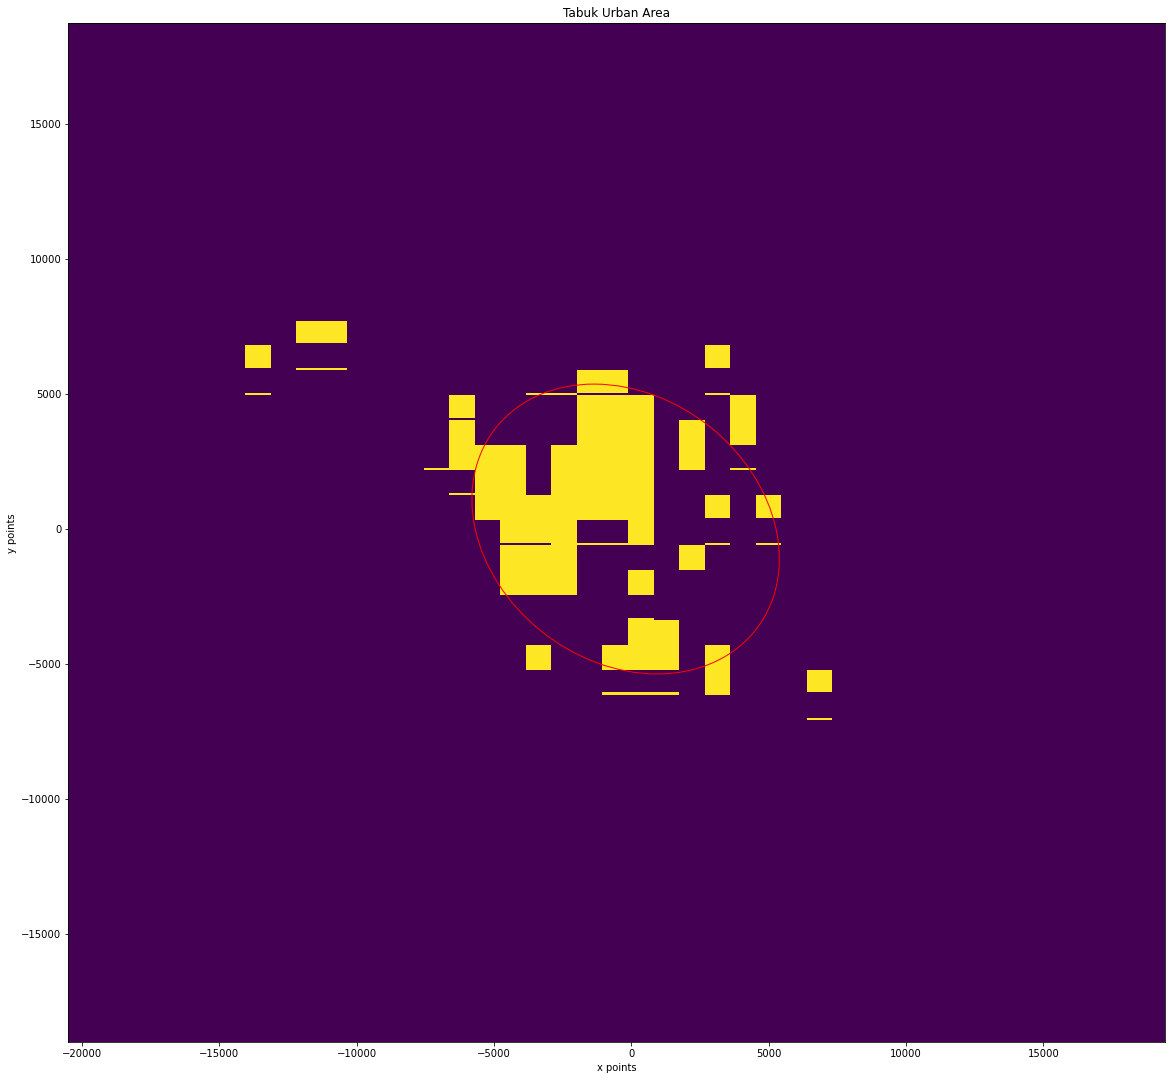

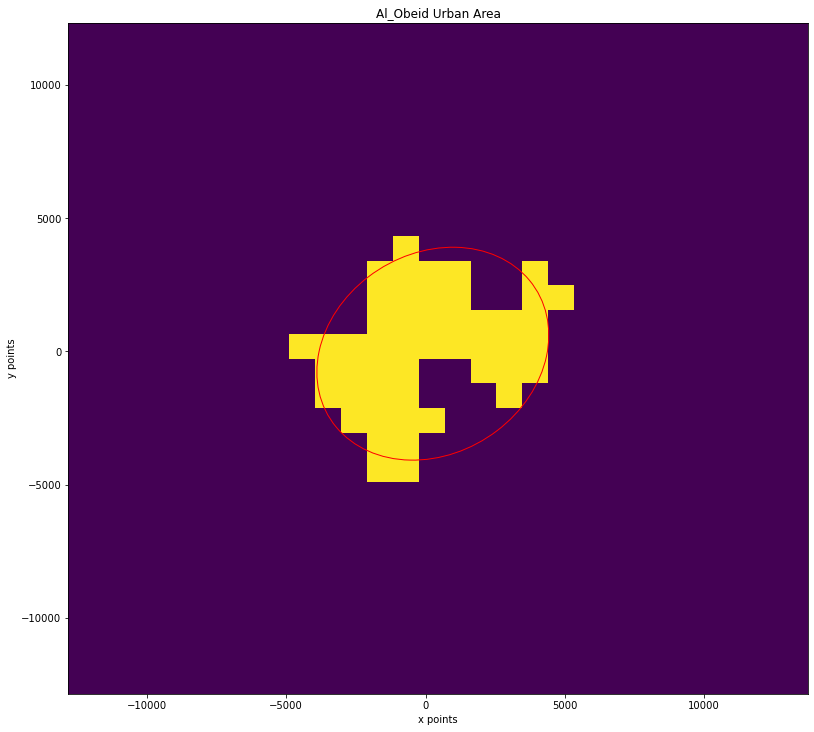

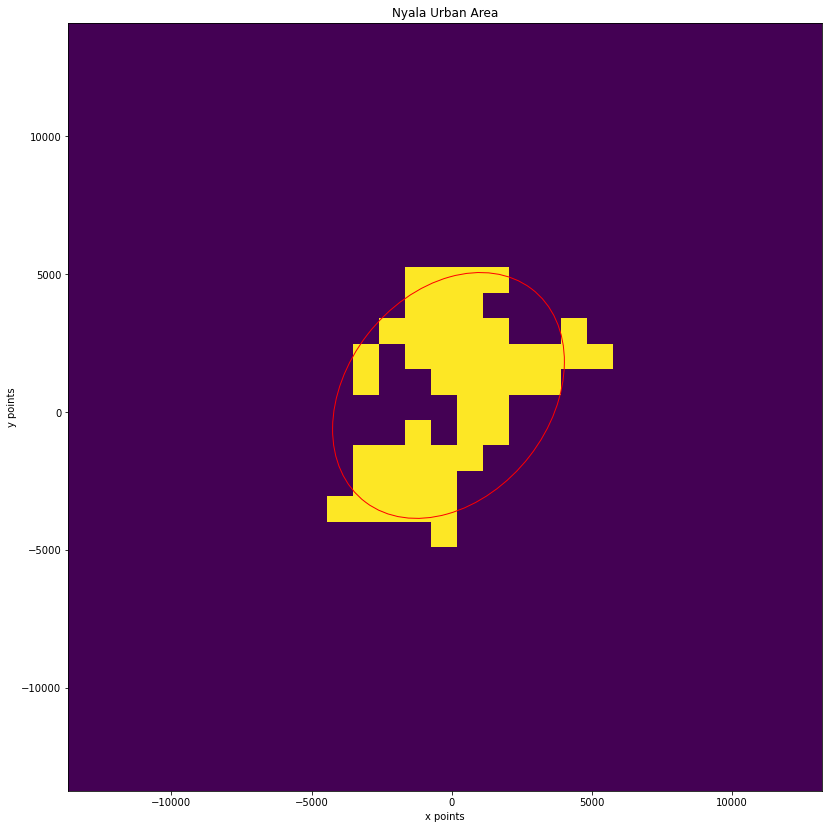

In [256]:
# plot and save figs with ellipses for all 2015 cities

for i_count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):    

    # load up LULC data for the city
    with open('UHI_Project_Pickle_Files\LULC_Pickles\Crop_wbuffer_LULC\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)   

    major_ax = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].major_ax_2015.values[0]
    minor_ax = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].minor_ax_2015.values[0]
    theta = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].ell_theta_2015.values[0] 
    city_name = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY)].City.values[0]
    #### CROPPED AREA ####
    x = LULC_df['x_points'].values
    y = LULC_df['y_points'].values
    U = LULC_df['is_urban_overall_2015'].values

    X,Y = np.meshgrid(x,y)
    Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
    fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
    axes.pcolormesh(X, Y, Z, shading = 'auto')
    axes.set_title('{} Urban Area'.format(city_name))
    axes.set_xlabel('x points')
    axes.set_ylabel('y points')

    
    city_x = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_2015'] == 1))].x_points.values

    city_y = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax)
                & (LULC_df['is_urban_overall_2015'] == 1))].y_points.values

    city_xy = np.array(list(zip(city_x, city_y)))

    ell.estimate(city_xy)

    xc, yc, a, b, theta2 = ell.params
    
    ell_patch = Ellipse((xc, yc), 2*(major_ax), 2*(minor_ax), theta*180/np.pi, edgecolor='red', facecolor='none')

    axes.add_patch(ell_patch)

    #save the plot as a png
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
    plt.savefig('{}_2015_ellipse.png'.format(city_name))

In [257]:
#save the updates to the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon.to_excel('CITY_COUNTRY_lat_lon.xlsx', index = False)
    